In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle/

# Copy the kaggle.json file from your Google Drive to the .kaggle directory
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/kaggle.json

# Set the correct permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download murtozalikhon/brain-tumor-multimodal-image-ct-and-mri

Dataset URL: https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri
License(s): CC-BY-NC-SA-4.0
 89% 320M/361M [00:03<00:00, 65.9MB/s]
100% 361M/361M [00:03<00:00, 102MB/s] 


In [ ]:
!unzip /content/brain-tumor-multimodal-image-ct-and-mri.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (10).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (100).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1000).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1001).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1002).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1003).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1004).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1005).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1006).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1007).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1008).jpg  
  inflating: Dataset/Brain Tumo

## Visualize Training Progress

Plot the training and validation loss and accuracy over epochs to visualize the model's learning progress and identify potential issues like overfitting.

## Visualize Preprocessing Effects

Display a few sample paired images *before* and *after* applying the preprocessing transformations (including data augmentation) to visually inspect the effects of resizing, rotation, and other augmentations.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

First, load the image paths and their corresponding labels for both CT and MRI scans using the `load_image_paths_and_labels` function. This function iterates through the category subfolders ('Healthy', 'Tumor') within the specified base paths, lists the image files, and returns a pandas DataFrame containing the image paths and their respective category labels.

In [ ]:
ct_scan_base_path = '/content/Dataset/Brain Tumor CT scan Images'
categories = ["Healthy","Tumor"]
mri_scan_base_path = '/content/Dataset/Brain Tumor MRI images'

In [ ]:
# Define the specific image names for the tumor images
sample_ct_tumor_image_name = "ct_tumor (9).jpg"
sample_mri_tumor_image_name = "tumor (9).jpg"

# Construct the full paths
sample_ct_tumor_image_path = os.path.join(ct_scan_base_path, "Tumor", sample_ct_tumor_image_name)
sample_mri_tumor_image_path = os.path.join(mri_scan_base_path, "Tumor", sample_mri_tumor_image_name)

# Print the constructed paths
print(f"Sample CT Tumor Image Path: {sample_ct_tumor_image_path}")
print(f"Sample MRI Tumor Image Path: {sample_mri_tumor_image_path}")

Sample CT Tumor Image Path: /content/Dataset/Brain Tumor CT scan Images/Tumor/ct_tumor (9).jpg
Sample MRI Tumor Image Path: /content/Dataset/Brain Tumor MRI images/Tumor/tumor (9).jpg


Encode the categorical labels ('Healthy', 'Tumor') into numerical format (0, 1) using `LabelEncoder` from scikit-learn. This is necessary for training the model.

Create a paired DataFrame that links corresponding CT and MRI image paths based on their filename patterns. This is a crucial step to ensure that the model is trained and evaluated on paired images.

Define a custom PyTorch Dataset class, `PairedBrainTumorDataset`, to load and preprocess the paired CT and MRI images. This dataset class will handle reading the images from the file paths specified in the paired DataFrame, applying transformations, and returning the paired image tensors and their corresponding labels.

In [ ]:
import os
import pandas as pd

def load_image_paths_and_labels(base_path, categories, limit_per_category=None):
    """
    Loads image paths and their corresponding labels from specified directories.

    Args:
        base_path (str): The base directory containing category subfolders.
        categories (list): A list of category names (subfolder names).
        limit_per_category (int, optional): Maximum number of images to load per category.
                                            Defaults to None (load all).

    Returns:
        pandas.DataFrame: A DataFrame with 'image_path' and 'label' columns.
    """
    image_paths = []
    labels = []

    for category in categories:
        category_path = os.path.join(base_path, category)
        print(f"Checking category path: {category_path}")


        if not os.path.exists(category_path):
            print(f"Warning: Category path not found: {category_path}")
            continue

        images = os.listdir(category_path)
        if limit_per_category is not None:
            images = images[:limit_per_category]

        for image_name in images:
            image_path = os.path.join(category_path, image_name)
            # Basic check to ensure it's a file (not a directory)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(category)

    return pd.DataFrame({
        "image_path": image_paths,
        "label": labels
    })

# Load CT image data
ct_scan_base_path = '/content/Dataset/Brain Tumor CT scan Images'
categories = ["Healthy","Tumor"]
print(f"Loading CT images from: {ct_scan_base_path}")
ct_df = load_image_paths_and_labels(ct_scan_base_path, categories, limit_per_category=2000)

# Load MRI image data (assuming similar structure)
mri_scan_base_path = '/content/Dataset/Brain Tumor MRI images'
print(f"Loading MRI images from: {mri_scan_base_path}")
mri_df = load_image_paths_and_labels(mri_scan_base_path, categories, limit_per_category=2000) # Applying same limit as CT

print("CT DataFrame Head:")
display(ct_df.head())
print("\nMRI DataFrame Head:")
display(mri_df.head())

Loading CT images from: /content/Dataset/Brain Tumor CT scan Images
Checking category path: /content/Dataset/Brain Tumor CT scan Images/Healthy
Checking category path: /content/Dataset/Brain Tumor CT scan Images/Tumor
Loading MRI images from: /content/Dataset/Brain Tumor MRI images
Checking category path: /content/Dataset/Brain Tumor MRI images/Healthy
Checking category path: /content/Dataset/Brain Tumor MRI images/Tumor
CT DataFrame Head:


,image_path,label
0,/content/Dataset/Brain Tumor CT scan Images/He...,Healthy
1,/content/Dataset/Brain Tumor CT scan Images/He...,Healthy
2,/content/Dataset/Brain Tumor CT scan Images/He...,Healthy
3,/content/Dataset/Brain Tumor CT scan Images/He...,Healthy
4,/content/Dataset/Brain Tumor CT scan Images/He...,Healthy



MRI DataFrame Head:


,image_path,label
0,/content/Dataset/Brain Tumor MRI images/Health...,Healthy
1,/content/Dataset/Brain Tumor MRI images/Health...,Healthy
2,/content/Dataset/Brain Tumor MRI images/Health...,Healthy
3,/content/Dataset/Brain Tumor MRI images/Health...,Healthy
4,/content/Dataset/Brain Tumor MRI images/Health...,Healthy


In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(dataframe, label_column='label'):
    """
    Encodes categorical labels into numerical format.

    Args:
        dataframe (pandas.DataFrame): The DataFrame containing the label column.
        label_column (str): The name of the column with categorical labels.

    Returns:
        tuple: A tuple containing:
            - pandas.DataFrame: The DataFrame with an added 'category_encoded' column.
            - sklearn.preprocessing.LabelEncoder: The fitted LabelEncoder object.
    """
    label_encoder = LabelEncoder()
    dataframe['category_encoded'] = label_encoder.fit_transform(dataframe[label_column])
    return dataframe, label_encoder

# Encode labels for both CT and MRI dataframes (although they should be the same categories)
ct_df, label_encoder_ct = encode_labels(ct_df.copy()) # Use .copy() to avoid modifying original df
mri_df, label_encoder_mri = encode_labels(mri_df.copy()) # Use .copy() to avoid modifying original df

# Keep only necessary columns
ct_df = ct_df[['image_path', 'category_encoded']]
mri_df = mri_df[['image_path', 'category_encoded']]

print("CT DataFrame after encoding:")
display(ct_df.head())
print("\nMRI DataFrame after encoding:")
display(mri_df.head())

CT DataFrame after encoding:


,image_path,category_encoded
0,/content/Dataset/Brain Tumor CT scan Images/He...,0
1,/content/Dataset/Brain Tumor CT scan Images/He...,0
2,/content/Dataset/Brain Tumor CT scan Images/He...,0
3,/content/Dataset/Brain Tumor CT scan Images/He...,0
4,/content/Dataset/Brain Tumor CT scan Images/He...,0



MRI DataFrame after encoding:


,image_path,category_encoded
0,/content/Dataset/Brain Tumor MRI images/Health...,0
1,/content/Dataset/Brain Tumor MRI images/Health...,0
2,/content/Dataset/Brain Tumor MRI images/Health...,0
3,/content/Dataset/Brain Tumor MRI images/Health...,0
4,/content/Dataset/Brain Tumor MRI images/Health...,0


In [ ]:
import re
import os
import pandas as pd

def create_paired_dataframe(ct_df, mri_df, categories, ct_base_path, mri_base_path):
    """
    Creates a DataFrame of paired CT and MRI image paths based on filename patterns.

    Args:
        ct_df (pandas.DataFrame): DataFrame with CT image paths and encoded categories.
        mri_df (pandas.DataFrame): DataFrame with MRI image paths and encoded categories.
        categories (list): List of category names.
        ct_base_path (str): Base path for CT images.
        mri_base_path (str): Base path for MRI images.


    Returns:
        pandas.DataFrame: A DataFrame with 'ct_image_path', 'mri_image_path',
                          and 'category_encoded' columns for paired images.
    """
    paired_image_paths = []
    mri_path_lookup = {}

    # Create a lookup dictionary for MRI paths based on filename and category
    for index, row in mri_df.iterrows():
        mri_path = row['image_path']
        mri_filename = os.path.basename(mri_path)
        category_encoded = row['category_encoded']
        category_name = categories[category_encoded]
        mri_path_lookup[(category_name, mri_filename)] = mri_path

    # Iterate through CT images and find corresponding MRI images
    for index, row in ct_df.iterrows():
        ct_image_path = row['image_path']
        category_encoded = row['category_encoded']
        category_name = categories[category_encoded]

        ct_filename = os.path.basename(ct_image_path)
        # Extract the number from the CT filename (e.g., '9' from 'ct_tumor (9).jpg')
        match = re.search(r'\((\d+)\)', ct_filename)

        mri_image_path = None

        if match:
            number = match.group(1)
            if category_name == "Tumor":
                # Expected MRI filename format for Tumor: tumor (X).jpg
                mri_filename_candidate = f"tumor ({number}).jpg"
            elif category_name == "Healthy":
                # Expected MRI filename format for Healthy: mri_healthy (X).jpg
                mri_filename_candidate = f"mri_healthy ({number}).jpg"

            # Check if the corresponding MRI file exists using the lookup
            if (category_name, mri_filename_candidate) in mri_path_lookup:
                 mri_image_path = mri_path_lookup[(category_name, mri_filename_candidate)]
            else:
                # Handle cases where the filename pattern might differ
                # For example, some healthy CT images are .png and some healthy MRI are .jpg
                # Let's check for healthy MRI images with the same number but .jpg extension
                if category_name == "Healthy":
                    mri_filename_candidate_jpg = f"mri_healthy ({number}).jpg"
                    if (category_name, mri_filename_candidate_jpg) in mri_path_lookup:
                        mri_image_path = mri_path_lookup[(category_name, mri_filename_candidate_jpg)]
                    # Also check for healthy CT .png and healthy MRI .png
                    elif ct_filename.endswith('.png'):
                         mri_filename_candidate_png = f"mri_healthy ({number}).png"
                         if (category_name, mri_filename_candidate_png) in mri_path_lookup:
                             mri_image_path = mri_path_lookup[(category_name, mri_filename_candidate_png)]


        # If a corresponding MRI image path was found, add the pair
        if mri_image_path is not None:
            paired_image_paths.append({
                'ct_image_path': ct_image_path,
                'mri_image_path': mri_image_path,
                'category_encoded': category_encoded
            })
        else:
            # Optional: Print a warning for unpaired images
            # print(f"Warning: Could not find paired MRI for CT: {ct_image_path}")
            pass


    return pd.DataFrame(paired_image_paths)

# Create the paired dataframe
paired_df = create_paired_dataframe(ct_df, mri_df, categories, ct_scan_base_path, mri_scan_base_path)


print("Paired DataFrame Head:")
display(paired_df.head())
print("\nPaired DataFrame Shape:")
print(paired_df.shape)

Paired DataFrame Head:


,ct_image_path,mri_image_path,category_encoded
0,/content/Dataset/Brain Tumor CT scan Images/He...,/content/Dataset/Brain Tumor MRI images/Health...,0
1,/content/Dataset/Brain Tumor CT scan Images/He...,/content/Dataset/Brain Tumor MRI images/Health...,0
2,/content/Dataset/Brain Tumor CT scan Images/He...,/content/Dataset/Brain Tumor MRI images/Health...,0
3,/content/Dataset/Brain Tumor CT scan Images/He...,/content/Dataset/Brain Tumor MRI images/Health...,0
4,/content/Dataset/Brain Tumor CT scan Images/He...,/content/Dataset/Brain Tumor MRI images/Health...,0



Paired DataFrame Shape:
(2403, 3)


In [ ]:
import torch
from torch.utils.data import Dataset
import cv2
from torchvision import transforms

class PairedBrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        ct_img_path = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('ct_image_path')]
        mri_img_path = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('mri_image_path')]
        label = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('category_encoded')]

        ct_image = cv2.imread(ct_img_path, cv2.IMREAD_GRAYSCALE)
        mri_image = cv2.imread(mri_img_path, cv2.IMREAD_GRAYSCALE)

        if ct_image is None:
            print(f"Warning: Could not load CT image at {ct_img_path}")
            ct_image_tensor = torch.zeros(1, 128, 128)
        else:
            if self.transform:
                ct_image_tensor = self.transform(ct_image)
            else:
                ct_image_tensor = torch.from_numpy(ct_image).unsqueeze(0).float() / 255.0 # Basic conversion

        if mri_image is None:
            print(f"Warning: Could not load MRI image at {mri_img_path}")
            mri_image_tensor = torch.zeros(1, 128, 128)
        else:
            if self.transform:
                mri_image_tensor = self.transform(mri_image)
            else:
                mri_image_tensor = torch.from_numpy(mri_image).unsqueeze(0).float() / 255.0 # Basic conversion

        # Return dummy label (-1) if either image failed to load
        if ct_image is None or mri_image is None:
             label = -1

        return ct_image_tensor, mri_image_tensor, label

Split the paired DataFrame into training, validation, and testing sets. This is essential for training and evaluating the model properly. Data augmentation transformations are also defined here and applied to the datasets.

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import cv2
import torch
from torchvision import transforms
import numpy as np

# Define image transformations
# These transformations should be applied consistently to both CT and MRI images
# You can define a single transform and apply it to both images in the dataset class
# Added Data Augmentation transforms
transform = transforms.Compose([
    transforms.ToPILImage(), # Convert numpy array to PIL Image
    transforms.Resize((128, 128)), # Resize to a consistent size
    transforms.RandomRotation(degrees=15), # Randomly rotate by +/- 15 degrees
    transforms.RandomHorizontalFlip(p=0.5), # Randomly flip horizontally
    transforms.RandomVerticalFlip(p=0.5), # Randomly flip vertically
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Randomly adjust brightness and contrast
    # Add other transformations here if needed (e.g., RandomAffine, RandomPerspective)
    transforms.ToTensor(), # Convert PIL Image to PyTorch Tensor (scales to [0, 1])
    # Add other transformations here if needed (e.g., normalization)
    # transforms.Normalize(mean=[0.5], std=[0.5]) # Example normalization for grayscale
])

# Assuming PairedBrainTumorDataset class is defined in cell 7cc01600

# Split paired_df
# Use stratify to ensure the proportion of classes is the same in train, validation, and test sets
# Check if paired_df is empty before splitting
if paired_df.empty:
    print("Error: paired_df is empty. Cannot perform train/validation/test split.")
    # You might want to handle this error more gracefully, e.g., exit or raise an exception.
    # For now, we'll just print a message and the cell will likely fail in the next lines.
else:
    train_paired_df, temp_paired_df = train_test_split(paired_df, test_size=0.3, random_state=42, stratify=paired_df['category_encoded'])
    valid_paired_df, test_paired_df = train_test_split(temp_paired_df, test_size=0.5, random_state=42, stratify=temp_paired_df['category_encoded'])

    # Create paired datasets
    train_paired_dataset = PairedBrainTumorDataset(train_paired_df, transform=transform)
    valid_paired_dataset = PairedBrainTumorDataset(valid_paired_df, transform=transform)
    test_paired_dataset = PairedBrainTumorDataset(test_paired_df, transform=transform)

    print("Paired Datasets:")
    print("Train:", len(train_paired_dataset))
    print("Validation:", len(valid_paired_dataset))
    print("Test:", len(test_paired_dataset))

Paired Datasets:
Train: 1682
Validation: 360
Test: 361


Visualizing 5 sample image pairs before and after preprocessing...


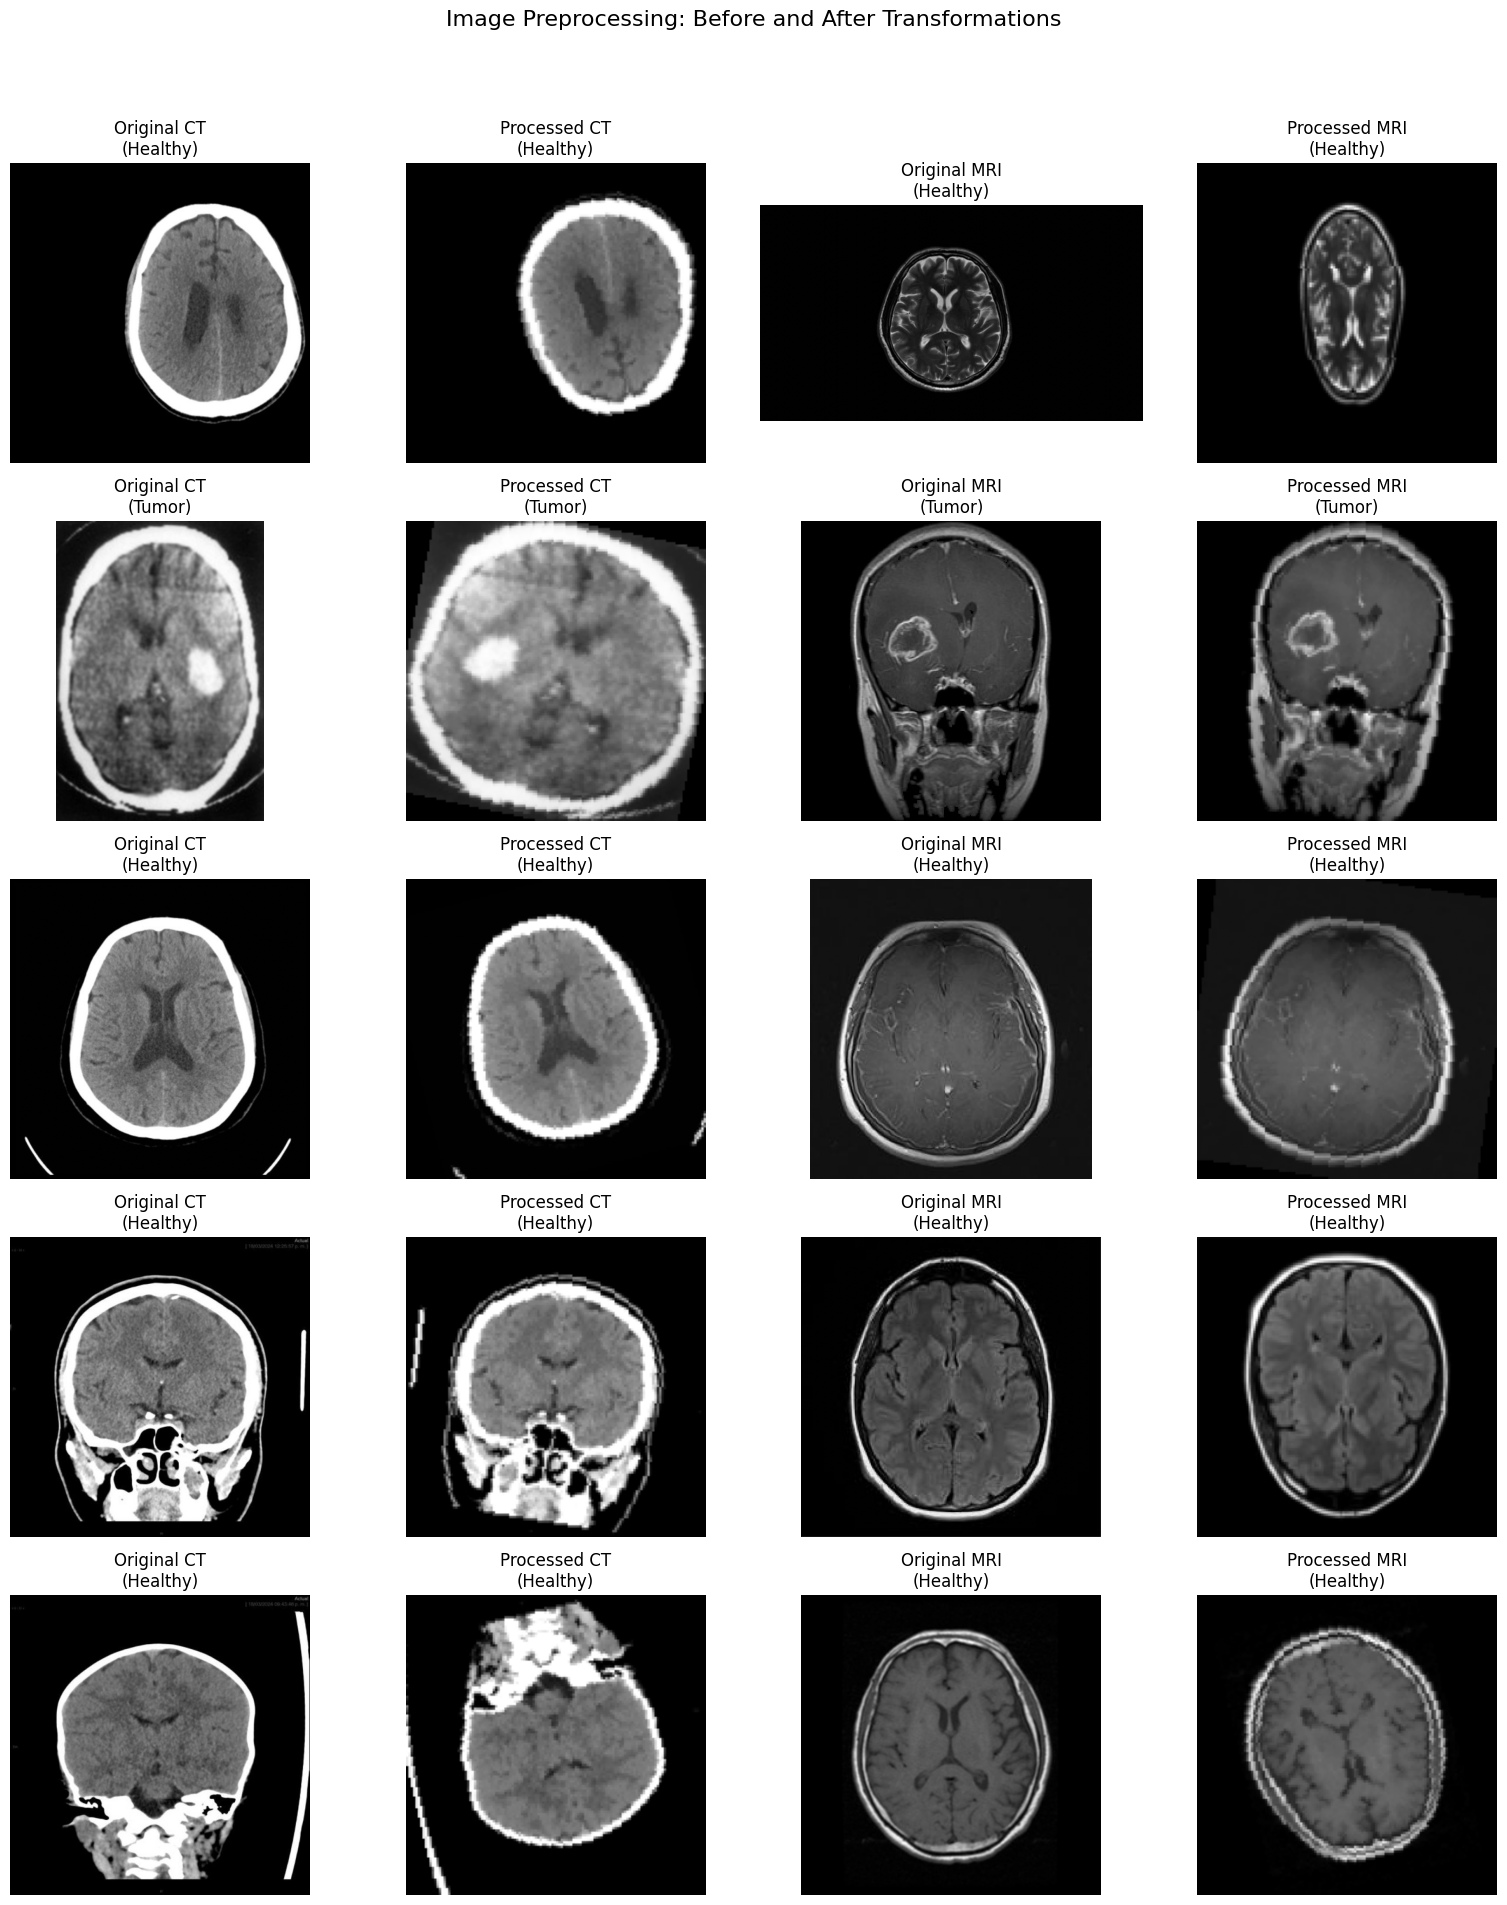

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch

def visualize_preprocessing(dataset, num_samples=3):
    """
    Visualizes original and preprocessed images from a paired dataset.

    Args:
        dataset (Dataset): The paired dataset (e.g., PairedBrainTumorDataset).
        num_samples (int): The number of samples to visualize.
    """
    print(f"Visualizing {num_samples} sample image pairs before and after preprocessing...")

    # Select random indices
    sample_indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 4))
    fig.suptitle("Image Preprocessing: Before and After Transformations", fontsize=16)

    for i, idx in enumerate(sample_indices):
        # Get the original image paths and label from the dataframe
        # Access the dataframe directly from the dataset object
        original_ct_path = dataset.dataframe.iloc[idx, dataset.dataframe.columns.get_loc('ct_image_path')]
        original_mri_path = dataset.dataframe.iloc[idx, dataset.dataframe.columns.get_loc('mri_image_path')]
        true_label = dataset.dataframe.iloc[idx, dataset.dataframe.columns.get_loc('category_encoded')]
        true_label_name = categories[true_label] # Assuming 'categories' list is defined

        # Load original images using cv2 for display before transformations
        original_ct_img = cv2.imread(original_ct_path, cv2.IMREAD_GRAYSCALE)
        original_mri_img = cv2.imread(original_mri_path, cv2.IMREAD_GRAYSCALE)

        # Get the preprocessed images from the dataset
        # The __getitem__ method applies the transform
        processed_ct_tensor, processed_mri_tensor, processed_label = dataset[idx]

        # Handle cases where original image loading failed
        if original_ct_img is None:
            print(f"Warning: Could not load original CT image at {original_ct_path}")
            original_ct_img_display = np.zeros((128, 128), dtype=np.uint8) # Placeholder
        else:
             # Resize original for consistent display size if needed, but keep aspect ratio ideally
             # For simple display, just show the loaded image
             original_ct_img_display = original_ct_img

        if original_mri_img is None:
             print(f"Warning: Could not load original MRI image at {original_mri_path}")
             original_mri_img_display = np.zeros((128, 128), dtype=np.uint8) # Placeholder
        else:
             original_mri_img_display = original_mri_img


        # Convert processed tensors back to numpy for display (squeeze channel dim)
        processed_ct_img_display = processed_ct_tensor.squeeze(0).cpu().numpy()
        processed_mri_img_display = processed_mri_tensor.squeeze(0).cpu().numpy()


        # Display Original CT
        axes[i, 0].imshow(original_ct_img_display, cmap='gray')
        axes[i, 0].set_title(f"Original CT\n({true_label_name})")
        axes[i, 0].axis('off')

        # Display Processed CT
        axes[i, 1].imshow(processed_ct_img_display, cmap='gray')
        axes[i, 1].set_title(f"Processed CT\n({true_label_name})")
        axes[i, 1].axis('off')

        # Display Original MRI
        axes[i, 2].imshow(original_mri_img_display, cmap='gray')
        axes[i, 2].set_title(f"Original MRI\n({true_label_name})")
        axes[i, 2].axis('off')

        # Display Processed MRI
        axes[i, 3].imshow(processed_mri_img_display, cmap='gray')
        axes[i, 3].set_title(f"Processed MRI\n({true_label_name})")
        axes[i, 3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

# Visualize preprocessing for the training dataset
# Assuming train_paired_dataset is defined in a previous cell (e.g., 437b9f5c)
if 'train_paired_dataset' in locals() and train_paired_dataset is not None:
    visualize_preprocessing(train_paired_dataset, num_samples=5) # Visualize 5 samples
else:
    print("Error: train_paired_dataset is not defined. Cannot visualize preprocessing.")

Create DataLoaders for the training, validation, and testing datasets. DataLoaders provide an iterable over the dataset, allowing for efficient batch processing during training and evaluation.

In [ ]:
from torch.utils.data import DataLoader

# Create DataLoaders for paired datasets
batch_size = 16

# Check if datasets are defined before creating DataLoaders
if 'train_paired_dataset' in locals() and train_paired_dataset is not None:
    train_paired_loader = DataLoader(train_paired_dataset, batch_size=batch_size, shuffle=True, num_workers=2) # Added num_workers
    valid_paired_loader = DataLoader(valid_paired_dataset, batch_size=batch_size, shuffle=False, num_workers=2) # Added num_workers
    test_paired_loader = DataLoader(test_paired_dataset, batch_size=batch_size, shuffle=False, num_workers=2) # Added num_workers

    print("Paired DataLoaders:")
    print("Train batches:", len(train_paired_loader))
    print("Validation batches:", len(valid_paired_loader))
    print("Test batches:", len(test_paired_loader))
else:
    print("Error: Paired datasets not defined. Cannot create DataLoaders.")

Paired DataLoaders:
Train batches: 106
Validation batches: 23
Test batches: 23


Define the `LightweightDualCrossModalTransformer` model architecture. This model incorporates CNN encoders, self-attention, and dual cross-attention mechanisms to process and fuse features from paired CT and MRI images for classification.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# CNN Encoder
class CNNEncoder(nn.Module):
    def __init__(self, in_channels, embed_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, embed_dim, 3, stride=2, padding=1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(2).transpose(1, 2)  # [B, N_patches, D]
        return x

# Cross-Attention Block returns (output_tensor, attention_weights)
class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim*2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim*2, embed_dim)
        )

    def forward(self, x, y):
        # x attends to y
        attn_out, attn_weights = self.cross_attn(query=x, key=y, value=y, need_weights=True)
        x = self.ln1(x + attn_out)
        x = self.ln2(x + self.ff(x))
        return x, attn_weights # Return attention weights

# Lightweight Dual-Modal Model with Dual Cross-Attention (Modified to remove CLS tokens)
class LightweightDualCrossModalTransformer(nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, num_classes=2):
        super().__init__()
        # CNN Encoders
        self.cnn_ct  = CNNEncoder(1, embed_dim)
        self.cnn_mri = CNNEncoder(1, embed_dim)

        # Self-Attention per modality (lightweight)
        self.self_attn_ct  = nn.TransformerEncoderLayer(embed_dim, num_heads, batch_first=True)
        self.self_attn_mri = nn.TransformerEncoderLayer(embed_dim, num_heads, batch_first=True)

        # Dual Cross-Attention
        self.cross_ct_to_mri = CrossAttentionBlock(embed_dim, num_heads)  # MRI attends to CT
        self.cross_mri_to_ct = CrossAttentionBlock(embed_dim, num_heads)  # CT attends to MRI

        # LayerNorms (applied after attention, before pooling)
        self.ln_ct  = nn.LayerNorm(embed_dim)
        self.ln_mri = nn.LayerNorm(embed_dim)

        # Classifier takes concatenated pooled features
        # Assuming Global Average Pooling over the sequence dimension
        self.fc = nn.Sequential(
            nn.Linear(embed_dim*2, 64), # Input dimension is embed_dim * 2
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, ct_img, mri_img):
        B = ct_img.size(0)
        # print(f"Input batch size (B): {B}")

        # CNN embeddings (output shape: [B, N_patches, embed_dim])
        ct  = self.cnn_ct(ct_img)
        mri = self.cnn_mri(mri_img)
        # print(f"CT CNN output shape: {ct.shape}")
        # print(f"MRI CNN output shape: {mri.shape}")

        # Self-attention
        ct  = self.self_attn_ct(ct)
        mri = self.self_attn_mri(mri)
        # print(f"CT Self-attention output shape: {ct.shape}")
        # print(f"MRI Self-attention output shape: {mri.shape}")

        # Dual Cross-Attention
        # CT attends to MRI (query=CT, key=MRI)
        ct, ct_mri_attn_weights = self.cross_mri_to_ct(ct, mri)
        # MRI attends to CT (query=MRI, key=CT)
        mri, mri_ct_attn_weights = self.cross_ct_to_mri(mri, ct)
        # print(f"CT after Cross-attention shape: {ct.shape}")
        # print(f"MRI after Cross-attention shape: {mri.shape}")
        # print(f"CT-MRI attention weights shape: {ct_mri_attn_weights.shape}")
        # print(f"MRI-CT attention weights shape: {mri_ct_attn_weights.shape}")

        # Apply LayerNorm after attention (optional, but good practice)
        ct = self.ln_ct(ct)
        mri = self.ln_mri(mri)

        # Apply Global Average Pooling over the sequence dimension
        ct_pooled = torch.mean(ct, dim=1) # Shape [B, D]
        mri_pooled = torch.mean(mri, dim=1) # Shape [B, D]
        # print(f"CT pooled shape: {ct_pooled.shape}")
        # print(f"MRI pooled shape: {mri_pooled.shape}")


        # Concatenate pooled features and classify
        fused = torch.cat([ct_pooled, mri_pooled], dim=1)
        # print(f"Fused features shape: {fused.shape}")
        logits = self.fc(fused)
        # print(f"Logits shape: {logits.shape}")
        return logits, ct_mri_attn_weights, mri_ct_attn_weights # Return logits and attention weights

Define functions for training and evaluating the model. The `train_model` function will handle the training loop, including forward and backward passes, optimization, and loss calculation. It also includes early stopping based on validation loss. The `evaluate_model` function will calculate the accuracy of the model on a given DataLoader.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# -------------------------------
# Training and Validation with Early Stopping
# -------------------------------
def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-4, weight_decay=0.0, device="cuda", patience=5):
    """
    Trains the model with early stopping.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for the training data.
        val_loader: DataLoader for the validation data.
        num_epochs (int): Maximum number of training epochs.
        lr (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay (L2 regularization) for the optimizer.
        device (str): Device to train on ('cpu' or 'cuda').
        patience (int): Number of epochs to wait for improvement before stopping.

    Returns:
        torch.nn.Module: The trained model.
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) # Added weight_decay

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        processed_samples_train = 0

        for ct_img, mri_img, labels in train_loader:
            # Filter out samples with invalid labels (-1)
            valid_indices = labels != -1
            if not torch.any(valid_indices):
                continue # Skip batch if no valid samples

            ct_img = ct_img[valid_indices].to(device)
            mri_img = mri_img[valid_indices].to(device)
            labels = labels[valid_indices].to(device)

            if labels.size(0) == 0:
                continue # Skip if no valid samples remain after filtering

            optimizer.zero_grad()
            # Model now returns logits and attention weights (or just logits for ablated)
            outputs = model(ct_img, mri_img)
            if isinstance(outputs, tuple):
                 logits = outputs[0] # Extract logits if model returns tuple
            else:
                 logits = outputs # Use outputs directly if model returns only logits


            # Explicitly reshape logits to ensure [batch_size, num_classes]
            # This addresses potential squeezing issues with batch size 1
            # Assuming num_classes is 2
            if logits.ndim == 1:
                logits = logits.unsqueeze(0) # Add batch dimension if it's squeezed
            # Ensure the number of classes dimension is 2
            if logits.size(-1) != 2:
                 # This might indicate a problem with the model's output shape
                 print(f"Warning: Model output logits size {logits.size()} does not match expected num_classes (2).")
                 # Attempt to reshape if possible, or raise an error
                 if logits.numel() == labels.size(0) * 2: # Check if total elements match expected [N, 2]
                      logits = logits.view(labels.size(0), 2)
                 else:
                      raise RuntimeError(f"Model output logits shape {logits.size()} is incompatible with labels size {labels.size()}.")


            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            processed_samples_train += labels.size(0)

        train_loss = running_loss / processed_samples_train if processed_samples_train > 0 else 0.0
        train_acc = correct / processed_samples_train if processed_samples_train > 0 else 0.0

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        processed_samples_val = 0
        with torch.no_grad():
            for ct_img, mri_img, labels in val_loader:
                # Filter out samples with invalid labels (-1)
                valid_indices = labels != -1
                if not torch.any(valid_indices):
                    continue # Skip batch if no valid samples

                ct_img = ct_img[valid_indices].to(device)
                mri_img = mri_img[valid_indices].to(device)
                labels = labels[valid_indices].to(device)

                if labels.size(0) == 0:
                    continue # Skip if no valid samples remain after filtering

                # Model now returns logits and attention weights (or just logits for ablated)
                outputs = model(ct_img, mri_img)
                if isinstance(outputs, tuple):
                     logits = outputs[0] # Extract logits if model returns tuple
                else:
                     logits = outputs # Use outputs directly if model returns only logits

                # Explicitly reshape logits to ensure [batch_size, num_classes]
                if logits.ndim == 1:
                    logits = logits.unsqueeze(0)
                if logits.size(-1) != 2:
                     if logits.numel() == labels.size(0) * 2:
                          logits = logits.view(labels.size(0), 2)
                     else:
                          print(f"Warning: Model output logits size {logits.size()} does not match expected num_classes (2) during validation.")
                          # Cannot reshape safely, continue with potentially incorrect shape or skip loss calc
                          # For now, let's proceed but be aware of potential issues
                          pass # Allow loss calculation to proceed, might fail

                loss = criterion(logits, labels)

                val_loss += loss.item() * labels.size(0)
                _, preds = torch.max(logits, 1)
                correct += (preds == labels).sum().item()
                processed_samples_val += labels.size(0)

        val_loss /= processed_samples_val if processed_samples_val > 0 else 0.0
        val_acc = correct / processed_samples_val if processed_samples_val > 0 else 0.0

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early Stopping
        # Check if val_loss is valid (not NaN)
        if not isinstance(val_loss, (int, float)) or not torch.isfinite(torch.tensor(val_loss)):
             print(f"Warning: Invalid validation loss ({val_loss}) at epoch {epoch+1}. Skipping early stopping check.")
             continue # Skip early stopping for this epoch if validation loss is invalid

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model state
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping after {epoch+1} epochs due to no improvement in validation loss.")
                break
    return model

#  Function that evaluates the model on the test set using a paired dataloader
def evaluate_model(model, test_loader, device="cpu"):
    """
    Evaluates the model on the test set.

    Args:
        model: The PyTorch model to evaluate.
        test_loader: DataLoader for the test data.
        device (str): Device to evaluate on ('cpu' or 'cuda').

    Returns:
        float: Test accuracy.
    """
    model = model.to(device)
    model.eval()
    correct, total = 0, 0
    processed_samples_test = 0 # counter for processed samples in evaluation
    with torch.no_grad():
        for ct_img, mri_img, labels in test_loader:
            # Filter out samples with invalid labels (-1)
            valid_indices = labels != -1
            if not torch.any(valid_indices):
                continue # Skip batch if no valid samples

            ct_img = ct_img[valid_indices].to(device)
            mri_img = mri_img[valid_indices].to(device)
            labels = labels[valid_indices].to(device)

            if labels.size(0) == 0:
                continue # Skip if no valid samples

            # Model returns logits and attention weights (or just logits for ablated)
            outputs = model(ct_img, mri_img)
            if isinstance(outputs, tuple):
                 logits = outputs[0] # Extract logits if model returns tuple
            else:
                 logits = outputs # Use outputs directly if model returns only logits

            # Explicitly reshape logits to ensure [batch_size, num_classes]
            # Assuming num_classes is 2
            if logits.ndim == 1:
                logits = logits.unsqueeze(0)
            if logits.size(-1) != 2:
                 # This might indicate a problem with the model's output shape
                 print(f"Warning: Model output logits size {logits.size()} does not match expected num_classes (2) during evaluation.")
                 # Cannot reshape safely, proceed with potentially incorrect shape or skip prediction
                 pass # Allow prediction to proceed, might fail


            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            processed_samples_test += labels.size(0) # Count only processed samples

    accuracy = correct / processed_samples_test if processed_samples_test > 0 else 0.0
    return accuracy

Train the `LightweightDualCrossModalTransformer` model using the defined training function and data loaders. This will train the model on the training data and evaluate its performance on the validation set during training, with early stopping to prevent overfitting. The trained model state is saved.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Instantiate the model
model = LightweightDualCrossModalTransformer(embed_dim=64, num_heads=2, num_classes=2).to(device)

# Train the model
print("Starting training...")

trained_model = train_model(
    model,
    train_paired_loader,
    valid_paired_loader,
    num_epochs=30,
    lr=1e-4,
    weight_decay=1e-4,
    device=device,
    patience=5
)
print("Training finished.")

# Save the final state of the trained model
torch.save(trained_model.state_dict(), 'full_model_final_state.pth')
print("Final trained model state saved to 'full_model_final_state.pth'")

# Evaluate the trained model
print("\nEvaluating the trained model on the test set...")
test_accuracy = evaluate_model(trained_model, test_paired_loader, device=device)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

Using device: cuda
Starting training...
Epoch 1/30 | Train Loss: 0.4480, Train Acc: 0.8306 | Val Loss: 0.4156, Val Acc: 0.8333
Epoch 2/30 | Train Loss: 0.3858, Train Acc: 0.8371 | Val Loss: 0.3631, Val Acc: 0.8306
Epoch 3/30 | Train Loss: 0.3515, Train Acc: 0.8543 | Val Loss: 0.4137, Val Acc: 0.8333
Epoch 4/30 | Train Loss: 0.3531, Train Acc: 0.8579 | Val Loss: 0.3510, Val Acc: 0.8583
Epoch 5/30 | Train Loss: 0.3332, Train Acc: 0.8662 | Val Loss: 0.3360, Val Acc: 0.8556
Epoch 6/30 | Train Loss: 0.3395, Train Acc: 0.8633 | Val Loss: 0.3577, Val Acc: 0.8639
Epoch 7/30 | Train Loss: 0.3347, Train Acc: 0.8633 | Val Loss: 0.3444, Val Acc: 0.8694
Epoch 8/30 | Train Loss: 0.3216, Train Acc: 0.8734 | Val Loss: 0.3127, Val Acc: 0.8833
Epoch 9/30 | Train Loss: 0.3019, Train Acc: 0.8900 | Val Loss: 0.2890, Val Acc: 0.9056
Epoch 10/30 | Train Loss: 0.2611, Train Acc: 0.9001 | Val Loss: 0.2594, Val Acc: 0.9028
Epoch 11/30 | Train Loss: 0.2632, Train Acc: 0.9049 | Val Loss: 0.2562, Val Acc: 0.9056
E

To calculate the confusion matrix, precision, recall, and F1-score, iterate through the `test_paired_loader` to get the model's predictions and the true labels for the entire test set. Store these in lists and then convert them to NumPy arrays.

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    """
    Plots the training and validation loss and accuracy over epochs.

    Args:
        train_losses (list): List of training losses per epoch.
        val_losses (list): List of validation losses per epoch.
        train_accs (list): List of training accuracies per epoch.
        val_accs (list): List of validation accuracies per epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Training Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Modify the train_model function to return the history
def train_model_with_history(model, train_loader, val_loader, num_epochs=20, lr=1e-4, weight_decay=0.0, device="cuda", patience=5):
    """
    Trains the model with early stopping and returns training history.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for the training data.
        val_loader: DataLoader for the validation data.
        num_epochs (int): Maximum number of training epochs.
        lr (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay (L2 regularization) for the optimizer.
        device (str): Device to train on ('cpu' or 'cuda').
        patience (int): Number of epochs to wait for improvement before stopping.

    Returns:
        tuple: A tuple containing:
            - torch.nn.Module: The trained model.
            - dict: A dictionary containing training history ('train_loss', 'val_loss', 'train_acc', 'val_acc').
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        processed_samples_train = 0

        for ct_img, mri_img, labels in train_loader:
            valid_indices = labels != -1
            if not torch.any(valid_indices):
                continue

            ct_img = ct_img[valid_indices].to(device)
            mri_img = mri_img[valid_indices].to(device)
            labels = labels[valid_indices].to(device)

            if labels.size(0) == 0:
                continue

            optimizer.zero_grad()
            outputs = model(ct_img, mri_img)
            if isinstance(outputs, tuple):
                 logits = outputs[0]
            else:
                 logits = outputs

            if logits.ndim == 1:
                logits = logits.unsqueeze(0)
            if logits.size(-1) != 2:
                 if logits.numel() == labels.size(0) * 2:
                      logits = logits.view(labels.size(0), 2)
                 else:
                      print(f"Warning: Model output logits size {logits.size()} does not match expected num_classes (2).")


            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            processed_samples_train += labels.size(0)


        train_loss = running_loss / processed_samples_train if processed_samples_train > 0 else 0.0
        train_acc = correct / processed_samples_train if processed_samples_train > 0 else 0.0

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        processed_samples_val = 0
        with torch.no_grad():
            for ct_img, mri_img, labels in val_loader:
                valid_indices = labels != -1
                if not torch.any(valid_indices):
                    continue

                ct_img = ct_img[valid_indices].to(device)
                mri_img = mri_img[valid_indices].to(device)
                labels = labels[valid_indices].to(device)

                if labels.size(0) == 0:
                    continue

                outputs = model(ct_img, mri_img)
                if isinstance(outputs, tuple):
                     logits = outputs[0]
                else:
                     logits = outputs

                if logits.ndim == 1:
                    logits = logits.unsqueeze(0)
                if logits.size(-1) != 2:
                     if logits.numel() == labels.size(0) * 2:
                          logits = logits.view(labels.size(0), 2)
                     else:
                          print(f"Warning: Model output logits size {logits.size()} does not match expected num_classes (2) during validation.")
                          pass


                loss = criterion(logits, labels)

                val_loss += loss.item() * labels.size(0)
                _, preds = torch.max(logits, 1)
                correct += (preds == labels).sum().item()
                processed_samples_val += labels.size(0)


        val_loss /= processed_samples_val if processed_samples_val > 0 else 0.0
        val_acc = correct / processed_samples_val if processed_samples_val > 0 else 0.0

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)


        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if not isinstance(val_loss, (int, float)) or not torch.isfinite(torch.tensor(val_loss)):
             print(f"Warning: Invalid validation loss ({val_loss}) at epoch {epoch+1}. Skipping early stopping check.")
             continue

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping after {epoch+1} epochs due to no improvement in validation loss.")
                break

    return model, history

# Example usage (assuming model, train_paired_loader, valid_paired_loader are defined):
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = LightweightDualCrossModalTransformer(embed_dim=64, num_heads=2, num_classes=2).to(device)
# trained_model, history = train_model_with_history(model, train_paired_loader, valid_paired_loader, num_epochs=30, lr=1e-4, device=device)
# plot_training_history(history['train_loss'], history['val_loss'], history['train_acc'], history['val_acc'])

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import torch

# 1. Initialize an empty list to store the predicted labels
all_predicted_labels = []
all_true_labels = []

# 2. Set the model to evaluation mode
trained_model.eval()

# 3. Disable gradient calculation
with torch.no_grad():
    # 4. Iterate through the test_paired_loader
    for ct_img, mri_img, labels in test_paired_loader:
        # 5. Move the CT and MRI images and labels to the specified device
        ct_img, mri_img, labels = ct_img.to(device), mri_img.to(device), labels.to(device)

        # 6. Get the model's logits for the paired images
        # Model now returns a tuple (logits, ct_mri_attn_weights, mri_ct_attn_weights)
        model_output = trained_model(ct_img, mri_img)
        logits = model_output[0] # Extract the logits tensor

        # 7. Get the predicted class label for each image in the batch
        _, predicted_classes = torch.max(logits, 1)

        # 8. Extend the list of predicted labels with the predicted labels from the current batch
        all_predicted_labels.extend(predicted_classes.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())


# 9. Convert the list of predicted labels to a NumPy array
all_predicted_labels = np.array(all_predicted_labels)

# 10. Extract the true labels from the test_paired_df and store them in a NumPy array.
# This was already done by appending labels in the loop, so just convert the list.
all_true_labels = np.array(all_true_labels)

print("Predicted labels obtained for the test set.")

Predicted labels obtained for the test set.


Calculate and display the confusion matrix, precision, recall, and F1-score using the true and predicted labels obtained in the previous step.

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Calculate precision, recall, and F1-score
precision = precision_score(all_true_labels, all_predicted_labels)
recall = recall_score(all_true_labels, all_predicted_labels)
f1 = f1_score(all_true_labels, all_predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Confusion Matrix:
[[292   8]
 [  9  52]]

Precision: 0.8667
Recall:    0.8525
F1-score:  0.8595


Calculate and plot the ROC curve and AUC score using the true labels and the model's predicted probabilities (logits) for the positive class.

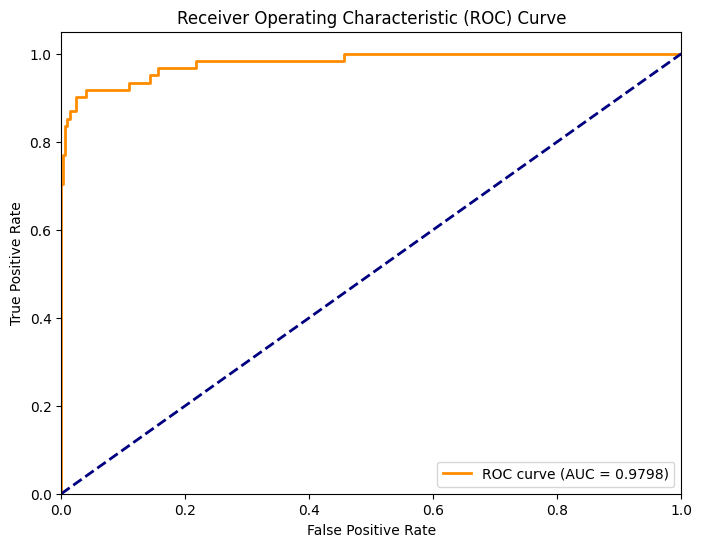

AUC: 0.9798


In [ ]:
# To calculate ROC curve and AUC, we need the predicted probabilities (logits)
# We need to re-run the prediction loop to get the logits

all_logits = []
all_true_labels = [] # Initialize list for true labels
trained_model.eval()
with torch.no_grad():
    for ct_img, mri_img, labels in test_paired_loader:
        # Move tensors to the correct device
        ct_img, mri_img = ct_img.to(device), mri_img.to(device)
        # Model now returns a tuple (logits, ct_mri_attn_weights, mri_ct_attn_weights)
        model_output = trained_model(ct_img, mri_img)
        logits = model_output[0] # Extract the logits tensor
        all_logits.extend(logits.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy()) # Collect true labels

all_logits = np.array(all_logits)
all_true_labels = np.array(all_true_labels) # Convert true labels list to numpy array


# Get the probabilities for the positive class (class 1)
all_probabilities = torch.softmax(torch.tensor(all_logits), dim=1)[:, 1].numpy()


# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_true_labels, all_probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.4f}")


**Improve the model performance by applying regularization, hyperparameter tuning, and cross-validation**

Add regularization techniques (e.g., weight decay) to the model's optimizer.


Define the hyperparameter grid for tuning, including parameters like learning rate, weight decay, embedding dimension, and number of attention heads.

Using device: cuda

Starting Hyperparameter Tuning with Grid Search over 16 combinations

--- Tuning Combination 1/16 with params: {'lr': 0.0001, 'weight_decay': 0.0, 'embed_dim': 32, 'num_heads': 1} ---
Epoch 1/20 | Train Loss: 0.4682, Train Acc: 0.8270 | Val Loss: 0.4363, Val Acc: 0.8333
Epoch 2/20 | Train Loss: 0.4207, Train Acc: 0.8371 | Val Loss: 0.3844, Val Acc: 0.8333
Epoch 3/20 | Train Loss: 0.3825, Train Acc: 0.8448 | Val Loss: 0.3571, Val Acc: 0.8500
Epoch 4/20 | Train Loss: 0.3612, Train Acc: 0.8401 | Val Loss: 0.3700, Val Acc: 0.8333
Epoch 5/20 | Train Loss: 0.3568, Train Acc: 0.8484 | Val Loss: 0.3523, Val Acc: 0.8556
Epoch 6/20 | Train Loss: 0.3388, Train Acc: 0.8621 | Val Loss: 0.3456, Val Acc: 0.8472
Epoch 7/20 | Train Loss: 0.3318, Train Acc: 0.8674 | Val Loss: 0.4056, Val Acc: 0.8167
Epoch 8/20 | Train Loss: 0.3304, Train Acc: 0.8710 | Val Loss: 0.3261, Val Acc: 0.8667
Epoch 9/20 | Train Loss: 0.3153, Train Acc: 0.8775 | Val Loss: 0.3103, Val Acc: 0.8833
Epoch 10/20 |

/tmp/ipython-input-1061565260.py:252: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  all_test_probabilities = torch.softmax(torch.tensor(all_test_logits), dim=1)[:, 1].numpy()


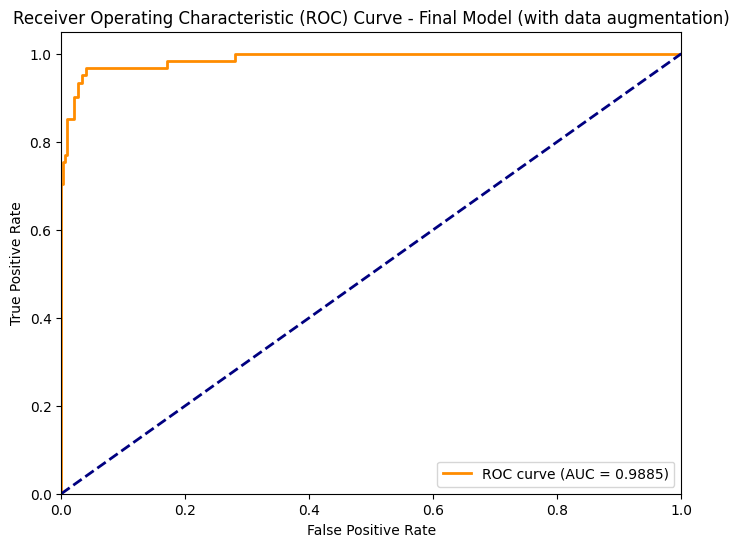

Test AUC: 0.9885


In [ ]:
import numpy as np
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

# Define the hyperparameter grid
param_grid = {
    'lr': [1e-4, 5e-5],
    'weight_decay': [0.0, 1e-4],
    'embed_dim': [32, 64],
    'num_heads': [1, 2]
}

# Create all combinations of hyperparameters
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
best_val_f1 = -1 # Track best validation F1 during tuning
best_params = None
all_tuning_results = []

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

print(f"\nStarting Hyperparameter Tuning with Grid Search over {len(param_combinations)} combinations")

for i, params in enumerate(param_combinations):
    print(f"\n--- Tuning Combination {i+1}/{len(param_combinations)} with params: {params} ---")
    params['dropout'] = 0.3

    # Instantiate a fresh model for each parameter combination
    # Use the model without CLS tokens based on ablation results (assuming this is the desired model)
    # If the user wants to tune the full model with CLS tokens, use LightweightDualCrossModalTransformer
    # Based on the request history, the user was exploring models without CLS tokens
    # Let's use LightweightDualCrossModalTransformer_NoCLS for tuning
    # Ensure LightweightDualCrossModalTransformer_NoCLS is defined (e.g., in cell 0d273c41)
    try:
        model = LightweightDualCrossModalTransformer(
            embed_dim=params['embed_dim'],
            num_heads=params['num_heads'],
            num_classes=2 # binary classification
        ).to(device)
    except NameError:
        print("Error: LightweightDualCrossModalTransformer class not defined. Skipping tuning for this combination.")
        all_tuning_results.append({'params': params, 'metrics': {'accuracy': np.nan, 'precision': np.nan, 'recall': np.nan, 'f1_score': np.nan}})
        continue # Skip to the next combination if class is not defined


    trained_model = train_model(
        model,
        train_paired_loader,
        valid_paired_loader,
        num_epochs=20,
        lr=params['lr'],
        weight_decay=params['weight_decay'],
        device=device,
        patience=5 # Use early stopping during tuning
    )

    # Evaluate the trained model on the augmented validation set and collect metrics
    model.eval()
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for ct_img, mri_img, labels in valid_paired_loader:
             valid_indices = labels != -1
             if not torch.any(valid_indices):
                 continue

             ct_img = ct_img[valid_indices].to(device)
             mri_img = mri_img[valid_indices].to(device)
             labels = labels[valid_indices].to(device)

             if labels.size(0) == 0:
                continue

             outputs = trained_model(ct_img, mri_img)
             if isinstance(outputs, tuple):
                 logits = outputs[0]
             else:
                 logits = outputs
             _, preds = torch.max(logits, 1)
             all_val_preds.extend(preds.cpu().numpy())
             all_val_labels.extend(labels.cpu().numpy())

    # Calculate performance metrics for this combination on the validation set
    # Check if all_val_labels is empty before calculating metrics
    if len(all_val_labels) > 0:
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        val_precision = precision_score(all_val_labels, all_val_preds, zero_division=0)
        val_recall = recall_score(all_val_labels, all_val_preds, zero_division=0)
        val_f1 = f1_score(all_val_labels, all_val_preds, zero_division=0)

        tuning_metrics = {
            'accuracy': val_accuracy,
            'precision': val_precision,
            'recall': val_recall,
            'f1_score': val_f1
        }

        all_tuning_results.append({'params': params, 'metrics': tuning_metrics})

        # Track the best parameters based on validation F1-score
        if tuning_metrics['f1_score'] > best_val_f1:
            best_val_f1 = tuning_metrics['f1_score']
            best_params = params

        print(f"Finished tuning for params: {params} with Val F1: {tuning_metrics['f1_score']:.4f}")
    else:
        print(f"Skipping evaluation for params {params} due to empty validation data.")
        all_tuning_results.append({'params': params, 'metrics': {'accuracy': np.nan, 'precision': np.nan, 'recall': np.nan, 'f1_score': np.nan}})


print("\n--- Hyperparameter Tuning Results (Sorted by Validation F1-score) ---")
# Sort results by validation F1-score (handle NaN values by placing them at the end)
all_tuning_results.sort(key=lambda x: x['metrics'].get('f1_score', -1), reverse=True)
for result in all_tuning_results:
    print(f"Params: {result['params']}, Val Metrics: {result['metrics']}")

print(f"\nBest Parameters found (based on Validation F1-score): {best_params}")

# --- Retrain the Final Model with Best Hyperparameters on the Full Training Data ---
if best_params:
    print("\nRetraining the final model with the best hyperparameters on the combined training and validation data (with augmentation) with Early Stopping...")

    # Combine train and validation dataframes
    combined_train_val_df = pd.concat([train_paired_df, valid_paired_df], ignore_index=True)

    # Create a new dataset and dataloader for the combined data, using the same augmentation transform
    combined_train_val_dataset = PairedBrainTumorDataset(combined_train_val_df, transform=transform)
    final_training_valid_loader = valid_paired_loader # Use original validation loader for early stopping
    combined_train_val_loader = DataLoader(combined_train_val_dataset, batch_size=16, shuffle=True, num_workers=2)

    # Instantiate the final model with the best hyperparameters
    # Use the LightweightDualCrossModalTransformer class for the final model
    try:
        final_model = LightweightDualCrossModalTransformer(
            embed_dim=best_params['embed_dim'],
            num_heads=best_params['num_heads'],
            num_classes=2
        ).to(device)
    except NameError:
         print("Error: LightweightDualCrossModalTransformer class not defined. Cannot train final model.")
         final_model = None # Prevent training if class is not defined


    if final_model is not None:
        # Train the final model on the combined dataset with early stopping on the validation set
        print("Training final model on the combined train and validation data...")

        # Use the existing train_model function which includes early stopping
        # The train_model function saves the best model state to 'best_model.pth'
        trained_final_model = train_model(
            final_model, # The model to train
            combined_train_val_loader, # Training data
            final_training_valid_loader, # Validation data for early stopping
            num_epochs=30, # Increase epochs as it's on more data and using early stopping
            lr=best_params['lr'],
            weight_decay=best_params['weight_decay'],
            device=device,
            patience=7 # Patience for early stopping on the validation set
        )

        # Explicitly save the state dictionary of the final trained model
        final_model_save_path = 'final_best_model_with_aug.pth'
        torch.save(trained_final_model.state_dict(), final_model_save_path)
        print(f"Final trained model state saved to '{final_model_save_path}'")

        # --- Evaluate the Final Model on the Independent Test Set ---
        print("\nEvaluating the final model on the independent test set (with data augmentation)...")

        # Load the best saved model state for final evaluation
        # The train_model function saves the best model state to 'best_model.pth'.
        # We should load this 'best_model.pth' for final evaluation as it's the one
        # that performed best on the validation set during the combined training.
        # Alternatively, if 'final_best_model_with_aug.pth' from the explicit save exists, load that.

        evaluation_model = LightweightDualCrossModalTransformer( # Instantiate with best params
            embed_dim=best_params['embed_dim'],
            num_heads=best_params['num_heads'],
            num_classes=2
        ).to(device)

        best_val_model_path = 'best_model.pth'
        final_explicit_save_path = 'final_best_model_with_aug.pth'
        loaded_eval_model_path = None

        if os.path.exists(final_explicit_save_path):
             evaluation_model.load_state_dict(torch.load(final_explicit_save_path, map_location=device))
             loaded_eval_model_path = final_explicit_save_path
             print(f"Loaded model state from '{loaded_eval_model_path}' for evaluation.")
        elif os.path.exists(best_val_model_path):
             evaluation_model.load_state_dict(torch.load(best_val_model_path, map_location=device))
             loaded_eval_model_path = best_val_model_path
             print(f"Loaded model state from '{loaded_eval_model_path}' (best from validation) for evaluation.")
        else:
             print(f"Error: Neither '{final_explicit_save_path}' nor '{best_val_model_path}' found. Cannot perform final evaluation.")
             loaded_eval_model_path = None # Indicate that loading failed


        if loaded_eval_model_path is not None:
            evaluation_model.eval()
            all_test_preds = []
            all_test_labels = []
            all_test_logits = []
            with torch.no_grad():
                for ct_img, mri_img, labels in test_paired_loader:
                    valid_indices = labels != -1
                    if not torch.any(valid_indices):
                        continue

                    ct_img = ct_img[valid_indices].to(device)
                    mri_img = mri_img[valid_indices].to(device)
                    labels = labels[valid_indices].to(device)

                    if labels.size(0) == 0:
                       continue

                    outputs = evaluation_model(ct_img, mri_img)
                    if isinstance(outputs, tuple):
                        logits = outputs[0]
                    else:
                        logits = outputs
                    _, preds = torch.max(logits, 1)

                    all_test_preds.extend(preds.cpu().numpy())
                    all_test_labels.extend(labels.cpu().numpy())
                    all_test_logits.extend(logits.cpu().numpy())

            # Calculate final test metrics
            if len(all_test_labels) > 0:
                final_test_accuracy = accuracy_score(all_test_labels, all_test_preds)
                final_test_precision = precision_score(all_test_labels, all_test_preds, zero_division=0)
                final_test_recall = recall_score(all_test_labels, all_test_preds, zero_division=0)
                final_test_f1 = f1_score(all_test_labels, all_test_preds, zero_division=0)
                final_test_conf_matrix = confusion_matrix(all_test_labels, all_test_preds)

                print("\n--- Final Model Performance on Test Set (with data augmentation) ---")
                print(f"Test Accuracy: {final_test_accuracy:.4f}")
                print(f"Test Precision: {final_test_precision:.4f}")
                print(f"Test Recall:    {final_test_recall:.4f}")
                print(f"Test F1-score:  {final_test_f1:.4f}")
                print("Confusion Matrix:")
                print(final_test_conf_matrix)

                # Calculate and plot ROC curve and AUC for the final model on the test set
                try:
                    all_test_probabilities = torch.softmax(torch.tensor(all_test_logits), dim=1)[:, 1].numpy()
                    fpr, tpr, thresholds = roc_curve(all_test_labels, all_test_probabilities)
                    final_test_roc_auc = auc(fpr, tpr)

                    plt.figure(figsize=(8, 6))
                    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {final_test_roc_auc:.4f})')
                    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('Receiver Operating Characteristic (ROC) Curve - Final Model (with data augmentation)')
                    plt.legend(loc="lower right")
                    plt.show()

                    print(f"Test AUC: {final_test_roc_auc:.4f}")

                except Exception as e:
                     print(f"Could not generate ROC curve: {e}")
                     final_test_roc_auc = np.nan # Set AUC to NaN if calculation fails

            else:
                 print("\nNo valid test data processed. Skipping final performance metrics calculation and ROC plot.")
                 final_test_accuracy = np.nan
                 final_test_precision = np.nan
                 final_test_recall = np.nan
                 final_test_f1 = np.nan
                 final_test_conf_matrix = "N/A (No valid test data)"
                 final_test_roc_auc = np.nan
        else:
             print("\nFinal model for evaluation could not be loaded. Skipping final evaluation.")

else:
    print("No best parameters found from tuning. Skipping final retraining and evaluation.")

Define a helper function `predict_image_pair` to make predictions on a single paired CT and MRI image. This function loads and preprocesses the images, sends them through the trained model, and returns the predicted class label.

In [ ]:
import cv2
import torch
from torchvision import transforms

def load_and_preprocess_image(image_path, img_size=(128, 128)):
    """
    Loads and preprocesses a single image.

    Args:
        image_path (str): Path to the image file.
        img_size (tuple): Desired output image size (width, height).

    Returns:
        torch.Tensor: Preprocessed image tensor, or None if loading fails.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Warning: Could not load image at {image_path}")
        return None

    # Resize the image
    image = cv2.resize(image, img_size)

    # Convert to tensor and normalize
    image_tensor = torch.from_numpy(image).unsqueeze(0).float() / 255.0 # Add channel dimension and normalize
    return image_tensor

import torch

def predict_image_pair(model, ct_image_path, mri_image_path, device="cpu"):
    """
    Predicts the label for a given CT and MRI image pair.

    Args:
        model: The trained PyTorch model.
        ct_image_path (str): Path to the CT image.
        mri_image_path (str): Path to the MRI image.
        device (str): Device to perform inference on ('cpu' or 'cuda').

    Returns:
        int: The predicted class label (0 for Healthy, 1 for Tumor),
             or None if image loading fails.
    """
    ct_image = load_and_preprocess_image(ct_image_path)
    mri_image = load_and_preprocess_image(mri_image_path)

    if ct_image is None or mri_image is None:
        return None  # Indicate error loading images

    # Add batch dimension and move to device
    ct_image = ct_image.unsqueeze(0).to(device)
    mri_image = mri_image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        model_output = model(ct_image, mri_image)
        # Check if the model output is a tuple (logits, attention_weights)
        if isinstance(model_output, tuple):
            logits = model_output[0] # Extract logits from the tuple
        else:
            logits = model_output # Assume output is just logits if not a tuple
        _, predicted_class = torch.max(logits, 1)

    return predicted_class.item()

Select a few sample paired images from the test set DataFrame (`test_paired_df`) for prediction and visualization. This will involve getting the file paths for the CT and MRI images, as well as their true and predicted labels.

Select and display sample paired images for visualization, including their file paths and true labels. This helps in visually inspecting the images that will be used for prediction and attention/Grad-CAM visualization. The code attempts to select an equal number of healthy and tumor samples if possible.

In [ ]:
# Select sample paired images for visualization
# Find indices for healthy and tumor cases in the test_paired_df
healthy_indices = test_paired_df[test_paired_df['category_encoded'] == 0].index.tolist()
tumor_indices = test_paired_df[test_paired_df['category_encoded'] == 1].index.tolist()

sample_indices_viz = []

# Select samples (to get an equal number of healthy and tumor)
num_samples_to_select = 6 #

# Add healthy samples
num_healthy_to_select = min(num_samples_to_select // 2, len(healthy_indices))
sample_indices_viz.extend(healthy_indices[:num_healthy_to_select])

# Add tumor samples
num_tumor_to_select = min(num_samples_to_select - len(sample_indices_viz), len(tumor_indices))
sample_indices_viz.extend(tumor_indices[:num_tumor_to_select])

# If not enough samples of one class, fill with the other class
if len(sample_indices_viz) < num_samples_to_select:
    remaining_needed = num_samples_to_select - len(sample_indices_viz)
    if len(sample_indices_viz) < len(healthy_indices):
        # Add more healthy samples if available
        healthy_indices_remaining = [idx for idx in healthy_indices if idx not in sample_indices_viz]
        sample_indices_viz.extend(healthy_indices_remaining[:remaining_needed])
        remaining_needed = num_samples_to_select - len(sample_indices_viz)
    if remaining_needed > 0 and len(sample_indices_viz) < len(tumor_indices):
         # Add more tumor samples if available
        tumor_indices_remaining = [idx for idx in tumor_indices if idx not in sample_indices_viz]
        sample_indices_viz.extend(tumor_indices_remaining[:remaining_needed])


# Ensure unique indices and shuffle for variety (optional)
sample_indices_viz = list(set(sample_indices_viz))
# random.shuffle(sample_indices_viz) # Uncomment if you want random samples each time

sample_paired_images_viz_df = test_paired_df.loc[sample_indices_viz]

sample_ct_image_paths_viz = sample_paired_images_viz_df['ct_image_path'].tolist()
sample_mri_image_paths_viz = sample_paired_images_viz_df['mri_image_path'].tolist()
sample_true_labels_viz = sample_paired_images_viz_df['category_encoded'].tolist()

# --- Add prediction for each sample ---
# Ensure the trained_final_model is available and on the correct device
device = "cuda" if torch.cuda.is_available() else "cpu"
# Assuming trained_final_model is available from previous cells
# If not, you might need to load it:
# from LightweightDualCrossModalTransformer import LightweightDualCrossModalTransformer # Assuming your model class is in a file or defined previously
# trained_final_model = LightweightDualCrossModalTransformer(embed_dim=64, num_heads=2, num_classes=2).to(device) # Use the correct model parameters
# trained_final_model.load_state_dict(torch.load('final_best_model_with_aug.pth', map_location=device))
# trained_final_model.eval() # Set to evaluation mode

sample_predicted_labels_viz = []
print("\nGenerating predictions for sample images...")
for i in range(len(sample_paired_images_viz_df)):
    ct_path = sample_ct_image_paths_viz[i]
    mri_path = sample_mri_image_paths_viz[i]
    # Use the predict_image_pair function defined in cell az4LU9rVuNlJ
    predicted_label = predict_image_pair(trained_final_model, ct_path, mri_path, device=device)
    sample_predicted_labels_viz.append(predicted_label)

print("Selected Sample Paired Image Paths, True Labels, and Predicted Labels for Visualization:")
categories = ["Healthy", "Tumor"] # Assuming categories list is available
for i in range(len(sample_paired_images_viz_df)):
    print(f"Sample {i}:")
    print(f"  CT Path: {sample_ct_image_paths_viz[i]}")
    print(f"  MRI Path: {sample_mri_image_paths_viz[i]}")
    print(f"  True Label: {sample_true_labels_viz[i]} ({categories[sample_true_labels_viz[i]]})")
    if sample_predicted_labels_viz[i] is not None:
         print(f"  Predicted Label: {sample_predicted_labels_viz[i]} ({categories[sample_predicted_labels_viz[i]]})")
    else:
         print(f"  Predicted Label: N/A (Image loading failed)")
    print("-" * 20)


Generating predictions for sample images...
Selected Sample Paired Image Paths, True Labels, and Predicted Labels for Visualization:
Sample 0:
  CT Path: /content/Dataset/Brain Tumor CT scan Images/Healthy/ct_healthy (950).jpg
  MRI Path: /content/Dataset/Brain Tumor MRI images/Healthy/mri_healthy (950).jpg
  True Label: 0 (Healthy)
  Predicted Label: 0 (Healthy)
--------------------
Sample 1:
  CT Path: /content/Dataset/Brain Tumor CT scan Images/Tumor/ct_tumor (21).png
  MRI Path: /content/Dataset/Brain Tumor MRI images/Tumor/tumor (21).jpg
  True Label: 1 (Tumor)
  Predicted Label: 1 (Tumor)
--------------------
Sample 2:
  CT Path: /content/Dataset/Brain Tumor CT scan Images/Tumor/ct_tumor (72).jpg
  MRI Path: /content/Dataset/Brain Tumor MRI images/Tumor/tumor (72).jpg
  True Label: 1 (Tumor)
  Predicted Label: 1 (Tumor)
--------------------
Sample 3:
  CT Path: /content/Dataset/Brain Tumor CT scan Images/Tumor/ct_tumor (353).jpg
  MRI Path: /content/Dataset/Brain Tumor MRI image

Define helper functions for visualizing attention maps and Grad-CAM heatmaps. `visualize_attention_map` overlays attention weights as a heatmap on an image, while `visualize_gradcam_heatmap` does the same for Grad-CAM results.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

def visualize_attention_map(original_image_path, attention_weights, patch_size=16, img_size=(128, 128), title="Attention Map"):
    """
    Visualizes attention weights as a heatmap overlaid on the original image.
    Args: original_image_path (str):, attention_weights (torch.Tensor): Attention weights for a single image pair (shape [B, num_heads, seq_len_query, seq_len_key], [num_heads, seq_len_query, seq_len_key], or [B=1, seq_len_query, seq_len_key]),
           patch_size (int): Size of the square patches used in the CNN,
        img_size (tuple): Size of the input image (width, height), title (str):
    """
    print(f"--- Inside visualize_attention_map ---")
    print(f"Received attention_weights shape: {attention_weights.shape}")

    original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    if original_image is None:
        print(f"Warning: Could not load image for visualization at {original_image_path}")
        return

    original_image = cv2.resize(original_image, img_size)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB) # Convert to RGB for heatmap overlay

    # Process attention weights based on received shape
    if attention_weights.ndim == 4 and attention_weights.size(0) == 1:
        # Expected shape [B=1, num_heads, seq_len_query, seq_len_key]
        attention_weights_processed = attention_weights.squeeze(0) # Shape [num_heads, seq_len_query, seq_len_key]
        print(f"Shape after squeezing batch (ndim=4, size 0=1): {attention_weights_processed.shape}")
        # Average across heads
        attention = torch.mean(attention_weights_processed, dim=0) # Shape [seq_len_query, seq_len_key]
        print(f"Shape after averaging heads: {attention.shape}")

    elif attention_weights.ndim == 3:
        # Expected shape [num_heads, seq_len_query, seq_len_key] (batch dimension already removed)
        attention_weights_processed = attention_weights
        print(f"Shape (ndim=3): {attention_weights_processed.shape}")
        # Average across heads
        attention = torch.mean(attention_weights_processed, dim=0) # Shape [seq_len_query, seq_len_key]
        print(f"Shape after averaging heads: {attention.shape}")

    elif attention_weights.ndim == 2 and attention_weights.shape == torch.Size([256, 256]):
        # Handling the unexpected shape [seq_len_query, seq_len_key]
        # Assuming this represents single-headed attention weights without batch dim
        print(f"Handling unexpected 2D shape [256, 256]. Assuming single head. Shape: {attention_weights.shape}")
        attention = attention_weights # Use directly as it's already [seq_len_query, seq_len_key]
        print(f"Shape after processing unexpected 2D shape: {attention.shape}")

    else:
         print(f"Warning: Attention weights shape is not in a supported format for visualization ({attention_weights.shape}). Expected [B=1, num_heads, seq_len_q, seq_len_k], [num_heads, seq_len_q, seq_len_k], or [B=1, seq_len_q, seq_len_k] or [seq_len_q, seq_len_k].")
         return

    # Now 'attention' should be in shape [seq_len_query, seq_len_key]

    # Average across query patches to get attention for each key patch
    # Assuming the query dimension is dim 0 and key dimension is dim 1
    attention = torch.mean(attention, dim=0) # Shape [seq_len_key]
    print(f"Shape after averaging query patches: {attention.shape}")


    num_patches = attention.shape[0]

    # Infer grid size from the number of patches (assuming a square grid)
    grid_size_actual = int(round(np.sqrt(num_patches)))
    print(f"Inferred grid size: {grid_size_actual}x{grid_size_actual}, Num patches: {num_patches}")
    if grid_size_actual * grid_size_actual != num_patches:
         print(f"Warning: Number of patches ({num_patches}) is not a perfect square ({grid_size_actual}x{grid_size_actual}). Cannot reshape attention for visualization.")
         # Fallback: try to use the closest square size if the difference is small
         closest_grid_size = round(np.sqrt(num_patches))
         if abs(closest_grid_size**2 - num_patches) <= 1: # Allow a small difference (e.g., 255 vs 256)
             grid_size_actual = closest_grid_size
             print(f"Attempting visualization with inferred grid size {grid_size_actual}x{grid_size_actual}.")
         else:
             return # Cannot proceed with visualization


    attention_grid = attention.reshape(grid_size_actual, grid_size_actual).cpu().detach().numpy()


    # Resize heatmap to match image size
    heatmap = cv2.resize(attention_grid, img_size)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on original image
    superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed_img)
    plt.title(title)
    plt.axis('off')
    plt.show()


def visualize_gradcam_heatmap(original_image_path, heatmap, img_size=(128, 128), title="Grad-CAM Heatmap"):
    """
    Visualizes Grad-CAM heatmap overlaid on the original image.
    Args: original_image_path (str):, heatmap (np.ndarray): Grad-CAM heatmap (shape [Batch=1, height, width] or [height, width]),
        img_size (tuple): Size the original image was resized to (width, height), title (str):
    """
    original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    if original_image is None:
        print(f"Warning: Could not load image for visualization at {original_image_path}")
        return

    original_image = cv2.resize(original_image, img_size)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB) # Convert to RGB for heatmap overlay

    # Ensure heatmap is 2D by squeezing the batch dimension if it exists
    if heatmap.ndim == 3 and heatmap.shape[0] == 1:
        heatmap_2d = heatmap.squeeze(0) # Remove the batch dimension
    elif heatmap.ndim == 2:
        heatmap_2d = heatmap # Heatmap is already 2D
    else:
        print(f"Warning: Grad-CAM heatmap is not 2D or 3D with batch size 1 (shape {heatmap.shape}). Cannot resize for visualization.")
        return


    # Resize the heatmap to the original image size (or the processed image size)
    heatmap_resized = cv2.resize(heatmap_2d, img_size)
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Superimpose heatmap on original image
    superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_colored, 0.4, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

Define a function `load_and_preprocess_image` to load and apply basic preprocessing to individual images (resizing and converting to tensor). This is a helper function used by the prediction and Grad-CAM visualization parts. Also, define `predict_image_pair_with_attention` which is similar to `predict_image_pair` but also returns attention weights from the model.

In [ ]:
import cv2
import torch
from torchvision import transforms

def load_and_preprocess_image(image_path, img_size=(128, 128)):
    """
    Loads and preprocesses a single image.
    Args: image_path (str), img_size (tuple): Desired output image size (width, height).
    Returns:torch.Tensor: Preprocessed image tensor, or None
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Warning: Could not load image at {image_path}")
        return None

    # Resize the image
    image = cv2.resize(image, img_size)

    # Convert to tensor and normalize
    image_tensor = torch.from_numpy(image).unsqueeze(0).float() / 255.0 # Add channel dimension and normalize
    return image_tensor

import torch

def predict_image_pair_with_attention(model, ct_image_path, mri_image_path, device="cpu"):
    """
    Predicts the label and returns attention weights for a given CT and MRI image pair.
    Args:model,Path to the CT image,Path to the MRI image,Device to perform inference on ('cpu' or 'cuda').
    Returns: tuple: - int: The predicted class label (0 for Healthy, 1 for Tumor),torch.Tensor: Attention weights from CT attending to MRI (shape [batch_size, num_heads, seq_len_ct, seq_len_mri]),
            - torch.Tensor: Attention weights from MRI attending to CT (shape [batch_size, num_heads, seq_len_mri, seq_len_ct]),
                            or None if image loading fails.
    """
    ct_image = load_and_preprocess_image(ct_image_path)
    mri_image = load_and_preprocess_image(mri_image_path)

    if ct_image is None or mri_image is None:
        return None, None, None  # Indicate error loading images

    # Add batch dimension and move to device
    ct_image = ct_image.unsqueeze(0).to(device)
    mri_image = mri_image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        model_output = model(ct_image, mri_image) # Model forward pass

        print(f"Inside predict_image_pair_with_attention:")
        print(f"  Type of model_output: {type(model_output)}")
        if isinstance(model_output, tuple):
             print(f"  Length of model_output tuple: {len(model_output)}")
             for i, item in enumerate(model_output):
                  if torch.is_tensor(item):
                       print(f"    Item {i} shape: {item.shape}")
                  else:
                       print(f"    Item {i} type: {type(item)}")
        else:
             if torch.is_tensor(model_output):
                  print(f"  Model output shape (not a tuple): {model_output.shape}")
             else:
                   print(f"  Model output type (not a tuple): {type(model_output)}")


        try:
            # Explicitly cast to tuple before unpacking
            model_output_tuple = tuple(model_output)
            # Unpacking assumes the order: logits, ct_mri_attn_weights, mri_ct_attn_weights
            logits, ct_mri_attn_weights, mri_ct_attn_weights = model_output_tuple
            _, predicted_class = torch.max(logits, 1)
            return predicted_class.item(), ct_mri_attn_weights, mri_ct_attn_weights
        except (TypeError, ValueError, IndexError) as e:
            print(f"Error unpacking model output: {e}")
            print(f"Model output type: {type(model_output)}")
            # print(f"Model output: {model_output}") # Avoid printing large tensors
            return None, None, None # Return None if unpacking fails

Generate predictions, attention weights, and Grad-CAM heatmaps for the selected sample paired images. This involves iterating through the sample images, predicting the class label, and then generating Grad-CAM heatmaps for both the CT and MRI images based on the predicted class. Finally, visualize the original images overlaid with attention maps and Grad-CAM heatmaps.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        # grad_output is a tuple, we need the gradient with respect to the output of the layer
        self.gradients = grad_output[0].detach()

    def __call__(self, inputs, target_category=None):
        # Clear previous gradients
        if hasattr(self.model, 'zero_grad'):
            self.model.zero_grad()
        else:
             # cases where the model might not have a zero_grad method directly
             for param in self.model.parameters():
                  if param.grad is not None:
                      param.grad.zero_()

        # Ensure inputs is a tuple even for single modality models for consistency
        if not isinstance(inputs, tuple):
             inputs = (inputs,)

        # Forward pass
        # Pass inputs to the model depending on how many inputs it expects
        if len(inputs) == 2:
             outputs = self.model(inputs[0], inputs[1])
        elif len(inputs) == 1:
             outputs = self.model(inputs[0])
        else:
             raise ValueError(f"Model expects 1 or 2 inputs, but received {len(inputs)}")


        # Assuming the model returns logits as the first element if it's a tuple
        if isinstance(outputs, tuple):
            logits = outputs[0]
        else:
            logits = outputs # Assume the output is logits if not a tuple

        # Get the predicted category if target_category is not specified
        if target_category is None:
            target_category = torch.argmax(logits, dim=1)
        else:
            # Convert target_category to a tensor if it's not already
            if not isinstance(target_category, torch.Tensor):
                target_category = torch.tensor(target_category, device=logits.device) # Ensure device matches logits

        # Handle potential multiple batch items for target_category
        if target_category.ndim == 0:
             target_category = target_category.unsqueeze(0) # Add batch dim if missing

        # Compute the loss for the target category
        # We need to select the score for the target class and backpropagate
        loss = torch.sum(logits * F.one_hot(target_category, num_classes=logits.size(-1)).float())

        # Backward pass
        loss.backward()

        # Check if gradients and activations were captured
        if self.gradients is None or self.activations is None:
             print("Error: Gradients or activations were not captured. Check if the target_layer is correctly registered and part of the computation graph.")
             return None, None # Return None heatmaps if capture failed

        # Get the gradients and activations
        gradients = self.gradients
        activations = self.activations

        # Handle potential batch size mismatch if gradients or activations have different batch sizes than inputs
        if gradients.size(0) != inputs[0].size(0) or activations.size(0) != inputs[0].size(0):
             print(f"Warning: Batch size mismatch between inputs ({inputs[0].size(0)}), gradients ({gradients.size(0)}), and activations ({activations.size(0)}).")
             # Attempt to proceed with the smallest batch size, or handle as an error
             min_batch_size = min(inputs[0].size(0), gradients.size(0), activations.size(0))
             gradients = gradients[:min_batch_size]
             activations = activations[:min_batch_size]
             # Adjust target_category if needed
             target_category = target_category[:min_batch_size]

        # Global Average Pooling of gradients
        # Average across spatial dimensions (assuming [B, C, H, W])
        # If gradients are [B, N_patches, D], average over N_patches
        if gradients.ndim == 4: # Standard CNN output
             pooled_gradients = torch.mean(gradients, dim=[2, 3], keepdim=True) # Shape [B, C, 1, 1]
        elif gradients.ndim == 3: # Transformer patch embeddings [B, N_patches, D]
             # Need to reshape gradients to spatial dimensions based on patch/grid size
             # A simpler approach for transformer patch gradients is to average over patches
             print("Warning: Gradients from transformer patches (3D). Averaging over patches instead of spatial pooling.")
             pooled_gradients = torch.mean(gradients, dim=1, keepdim=True) # Shape [B, 1, D] - This is not typical for GradCAM on spatial features
             # Reshape gradients to spatial
             # Let's assume the CNNEncoder output before flatten was [B, C, H', W']
             # N_patches = H' * W'
             # D = embed_dim
             # The gradients from the transformer layer are [B, N_patches, D]
             # We need to reshape these gradients back to [B, C, H', W'] where C is the last CNN channel count (embed_dim)
             # And H', W' are the spatial dimensions after the last conv layer.
             # From CNNEncoder definition: 3 conv layers with stride 2. Image size 128x128.
             # 128 -> 64 -> 32 -> 16
             # So H'=16, W'=16. Number of patches = 16*16 = 256. embed_dim = 64
             # Reshape gradients from [B, 256, embed_dim] to [B, embed_dim, 16, 16]
             B, N_patches, D = gradients.shape
             H_prime = W_prime = int(N_patches**0.5) # Assuming square grid
             if H_prime * W_prime == N_patches and D == activations.size(1): # Verify dimensions match expected
                  # Reshape gradients from [B, N_patches, D] to [B, D, H', W']
                  gradients_spatial = gradients.transpose(1, 2).reshape(B, D, H_prime, W_prime)
                  # Activations from Conv[-1] are already spatial [B, C, H', W']
                  activations_spatial = activations

                  # Recompute pooled_gradients using spatial gradients
                  pooled_gradients = torch.mean(gradients_spatial, dim=[2, 3], keepdim=True) # Shape [B, D, 1, 1]

                  # Update variables to use spatial versions for the next steps
                  gradients = gradients_spatial
                  activations = activations_spatial

                  # print("Reshaped gradients and activations to spatial for GradCAM.")

             else:
                 print("Could not reshape gradients and activations to spatial for standard GradCAM calculation.")
                 # Fallback: use the non-spatial average pooled gradients if reshaping failed
                 pass


        # Compute the weighted combination of activations
        # If pooled_gradients is [B, C, 1, 1] and activations is [B, C, H, W], broadcasting works.
        # We'll assume the spatial reshape was successful if gradients were 3D and dimensions matched.

        # using spatial gradients/activations:
        if gradients.ndim == 4 and activations.ndim == 4:
             weighted_activations = activations * pooled_gradients # Shape [B, C, H', W']
             # Apply ReLU to the weighted activations
             cam = F.relu(torch.sum(weighted_activations, dim=1, keepdim=True)) # Shape [B, 1, H', W']

             # Normalize the heatmap
             # Avoid division by zero
             cam_min = torch.min(cam.view(cam.size(0), -1), dim=1, keepdim=True)[0].unsqueeze(-1).unsqueeze(-1) # Shape [B, 1, 1, 1]
             cam_max = torch.max(cam.view(cam.size(0), -1), dim=1, keepdim=True)[0].unsqueeze(-1).unsqueeze(-1) # Shape [B, 1, 1, 1]

             # Add a small epsilon to avoid division by zero if max == min
             epsilon = 1e-8
             normalized_cam = (cam - cam_min) / (cam_max - cam_min + epsilon) # Shape [B, 1, H', W']

             # Resize heatmap to the original image size (or the size used for model input)
             # Assuming img_size was (128, 128) for the model input
             img_height, img_width = inputs[0].size(-2), inputs[0].size(-1) # Get height and width from input tensor
             heatmaps = F.interpolate(normalized_cam, size=(img_height, img_width), mode='bilinear', align_corners=False)

             # Return heatmaps for each image in the batch
             # Squeeze the channel dimension (from [B, 1, H, W] to [B, H, W]) and convert to numpy
             heatmaps_np = heatmaps.squeeze(1).cpu().numpy() # Shape [B, H, W]

             # Return raw cam before normalization and resizing as well (optional)
             # raw_cams = cam.squeeze(1).cpu().numpy() # Shape [B, H', W'] # Uncomment if needed

             return heatmaps_np, heatmaps # Return numpy array of heatmaps and tensor heatmaps

        else:
             print("Could not perform standard GradCAM calculation due to incompatible gradient/activation shapes.")
             return None, None


Generating predictions, attention weights, and Grad-CAM heatmaps for sample images
Inside predict_image_pair_with_attention:
  Type of model_output: <class 'tuple'>
  Length of model_output tuple: 3
    Item 0 shape: torch.Size([1, 2])
    Item 1 shape: torch.Size([1, 256, 256])
    Item 2 shape: torch.Size([1, 256, 256])
Sample 1 - Shape of ct_mri_attn returned by predict_image_pair_with_attention: torch.Size([1, 256, 256])
Sample 1 - Shape of mri_ct_attn returned by predict_image_pair_with_attention: torch.Size([1, 256, 256])
Inside predict_image_pair_with_attention:
  Type of model_output: <class 'tuple'>
  Length of model_output tuple: 3
    Item 0 shape: torch.Size([1, 2])
    Item 1 shape: torch.Size([1, 256, 256])
    Item 2 shape: torch.Size([1, 256, 256])
Sample 2 - Shape of ct_mri_attn returned by predict_image_pair_with_attention: torch.Size([1, 256, 256])
Sample 2 - Shape of mri_ct_attn returned by predict_image_pair_with_attention: torch.Size([1, 256, 256])
Inside predict

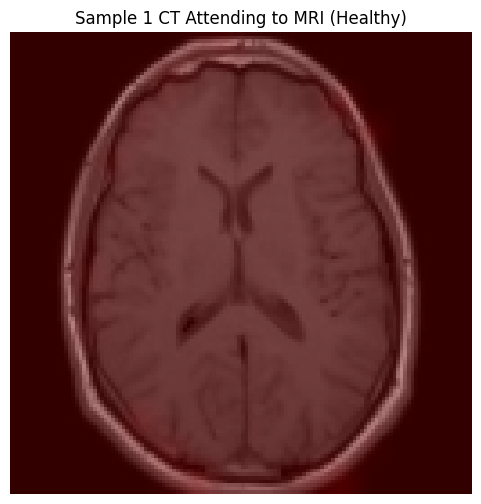

--- Inside visualize_attention_map ---
Received attention_weights shape: torch.Size([256, 256])
Handling unexpected 2D shape [256, 256]. Assuming single head. Shape: torch.Size([256, 256])
Shape after processing unexpected 2D shape: torch.Size([256, 256])
Shape after averaging query patches: torch.Size([256])
Inferred grid size: 16x16, Num patches: 256


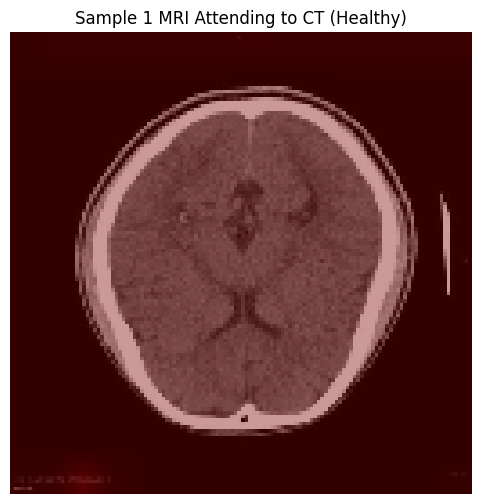

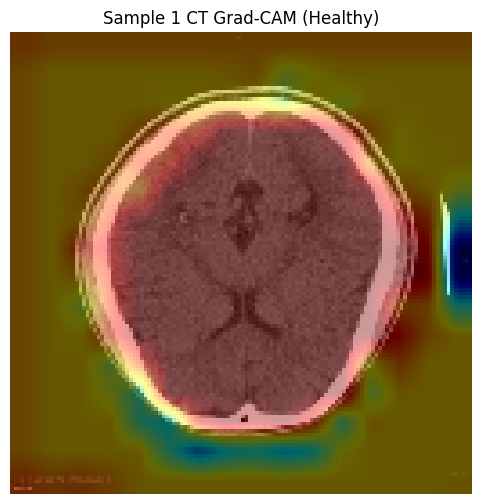

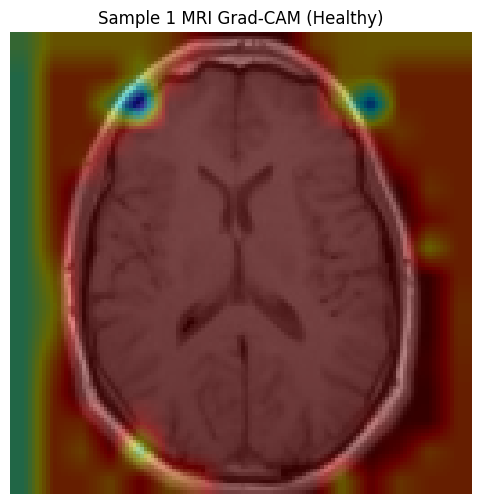


--- Sample 2: True Label: Tumor, Predicted Label: Tumor ---
--- Inside visualize_attention_map ---
Received attention_weights shape: torch.Size([256, 256])
Handling unexpected 2D shape [256, 256]. Assuming single head. Shape: torch.Size([256, 256])
Shape after processing unexpected 2D shape: torch.Size([256, 256])
Shape after averaging query patches: torch.Size([256])
Inferred grid size: 16x16, Num patches: 256


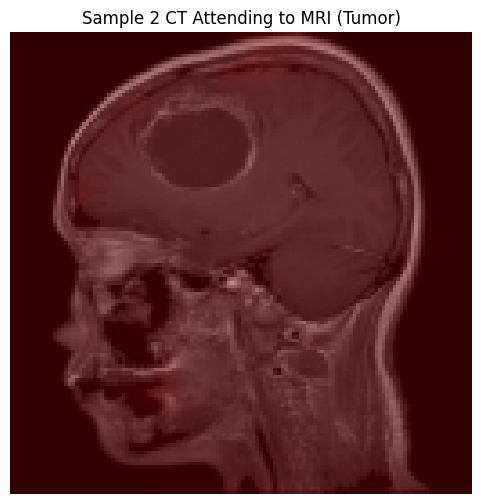

--- Inside visualize_attention_map ---
Received attention_weights shape: torch.Size([256, 256])
Handling unexpected 2D shape [256, 256]. Assuming single head. Shape: torch.Size([256, 256])
Shape after processing unexpected 2D shape: torch.Size([256, 256])
Shape after averaging query patches: torch.Size([256])
Inferred grid size: 16x16, Num patches: 256


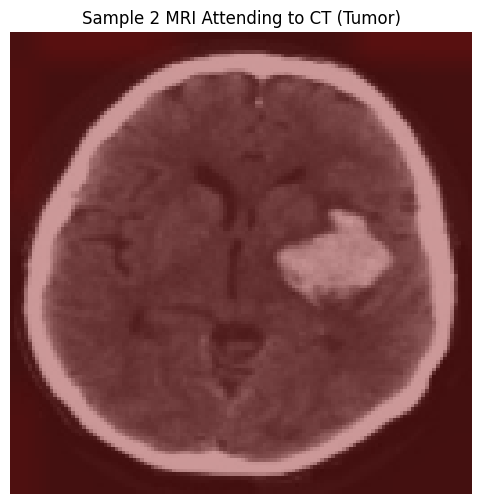

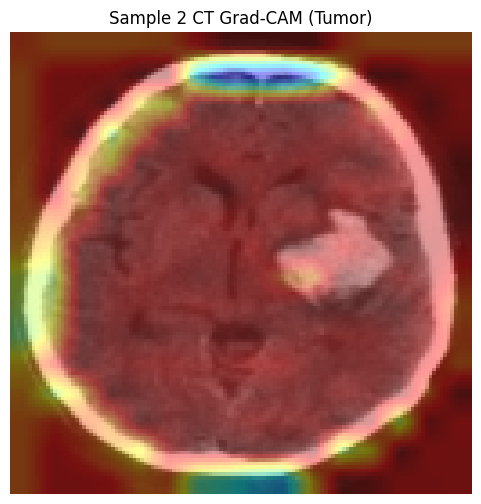

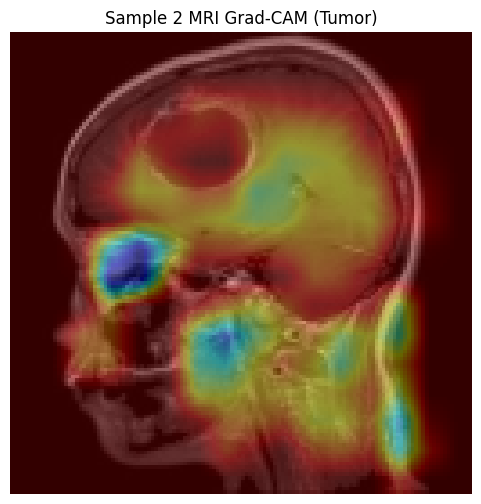


--- Sample 3: True Label: Tumor, Predicted Label: Tumor ---
--- Inside visualize_attention_map ---
Received attention_weights shape: torch.Size([256, 256])
Handling unexpected 2D shape [256, 256]. Assuming single head. Shape: torch.Size([256, 256])
Shape after processing unexpected 2D shape: torch.Size([256, 256])
Shape after averaging query patches: torch.Size([256])
Inferred grid size: 16x16, Num patches: 256


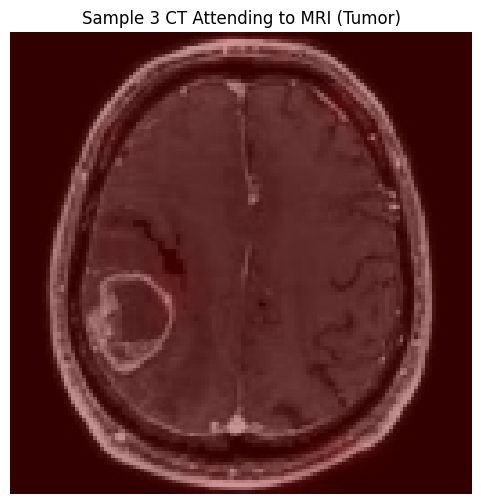

--- Inside visualize_attention_map ---
Received attention_weights shape: torch.Size([256, 256])
Handling unexpected 2D shape [256, 256]. Assuming single head. Shape: torch.Size([256, 256])
Shape after processing unexpected 2D shape: torch.Size([256, 256])
Shape after averaging query patches: torch.Size([256])
Inferred grid size: 16x16, Num patches: 256


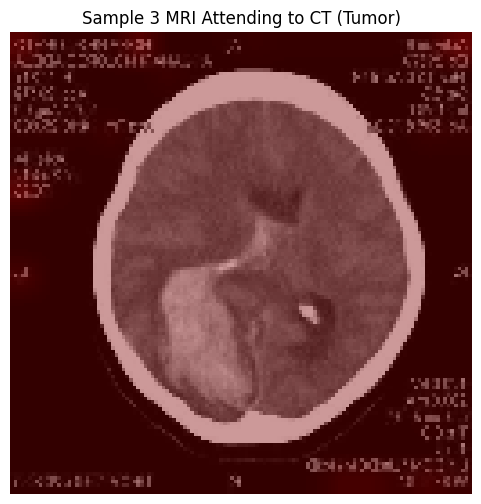

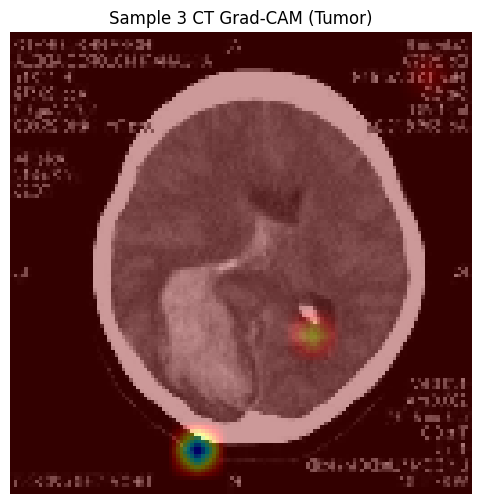

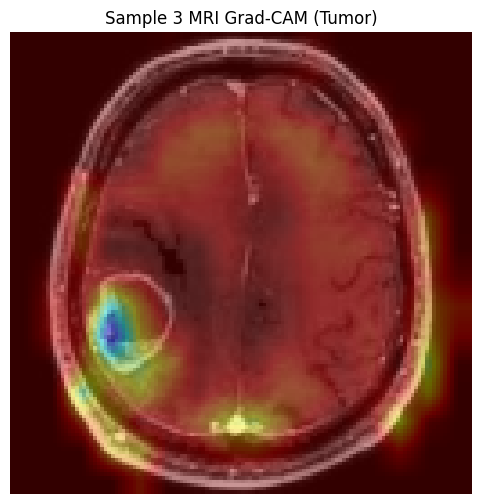


--- Sample 4: True Label: Tumor, Predicted Label: Tumor ---
--- Inside visualize_attention_map ---
Received attention_weights shape: torch.Size([256, 256])
Handling unexpected 2D shape [256, 256]. Assuming single head. Shape: torch.Size([256, 256])
Shape after processing unexpected 2D shape: torch.Size([256, 256])
Shape after averaging query patches: torch.Size([256])
Inferred grid size: 16x16, Num patches: 256


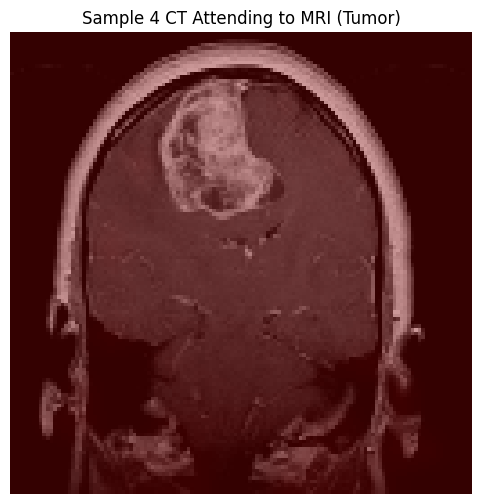

--- Inside visualize_attention_map ---
Received attention_weights shape: torch.Size([256, 256])
Handling unexpected 2D shape [256, 256]. Assuming single head. Shape: torch.Size([256, 256])
Shape after processing unexpected 2D shape: torch.Size([256, 256])
Shape after averaging query patches: torch.Size([256])
Inferred grid size: 16x16, Num patches: 256


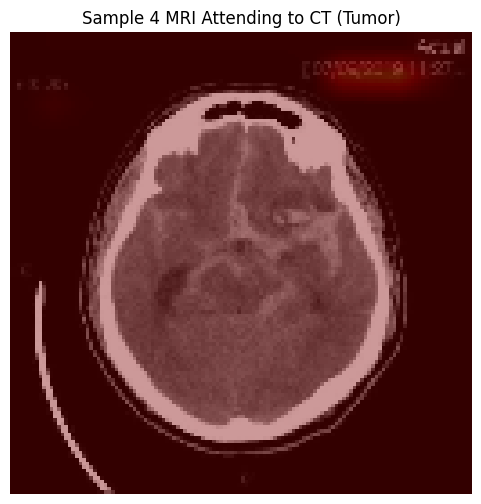

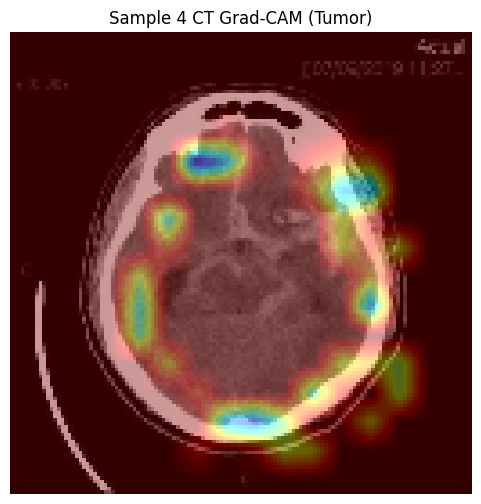

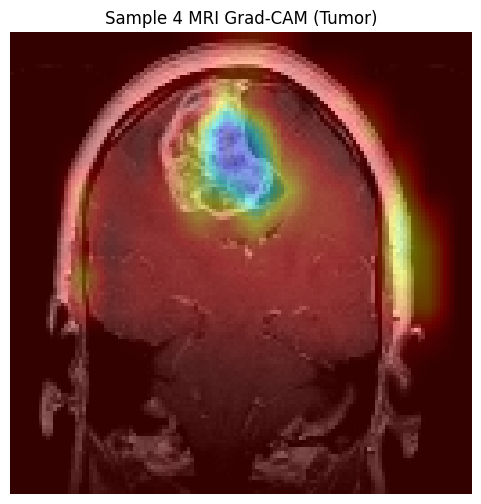


--- Sample 5: True Label: Healthy, Predicted Label: Healthy ---
--- Inside visualize_attention_map ---
Received attention_weights shape: torch.Size([256, 256])
Handling unexpected 2D shape [256, 256]. Assuming single head. Shape: torch.Size([256, 256])
Shape after processing unexpected 2D shape: torch.Size([256, 256])
Shape after averaging query patches: torch.Size([256])
Inferred grid size: 16x16, Num patches: 256


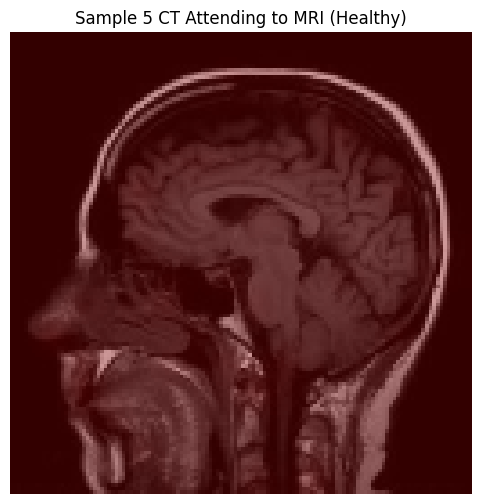

--- Inside visualize_attention_map ---
Received attention_weights shape: torch.Size([256, 256])
Handling unexpected 2D shape [256, 256]. Assuming single head. Shape: torch.Size([256, 256])
Shape after processing unexpected 2D shape: torch.Size([256, 256])
Shape after averaging query patches: torch.Size([256])
Inferred grid size: 16x16, Num patches: 256


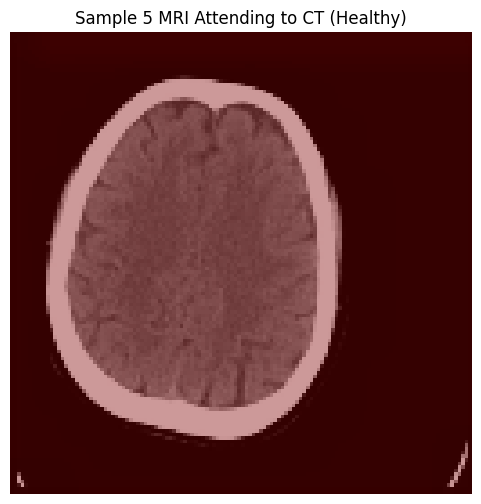

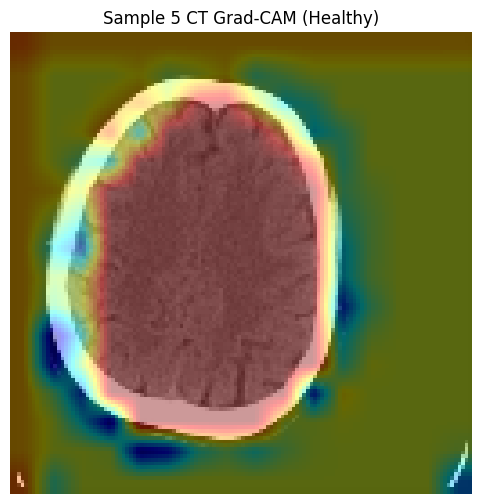

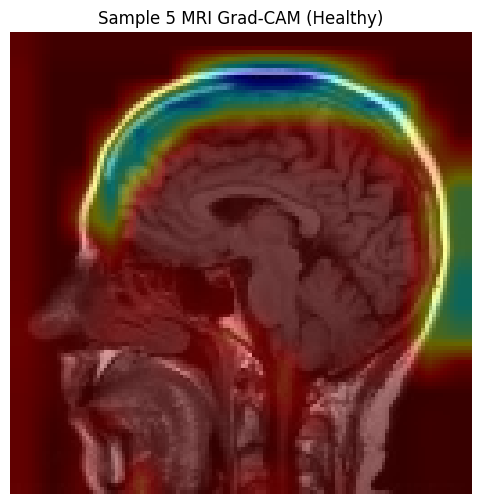


--- Sample 6: True Label: Healthy, Predicted Label: Healthy ---
--- Inside visualize_attention_map ---
Received attention_weights shape: torch.Size([256, 256])
Handling unexpected 2D shape [256, 256]. Assuming single head. Shape: torch.Size([256, 256])
Shape after processing unexpected 2D shape: torch.Size([256, 256])
Shape after averaging query patches: torch.Size([256])
Inferred grid size: 16x16, Num patches: 256


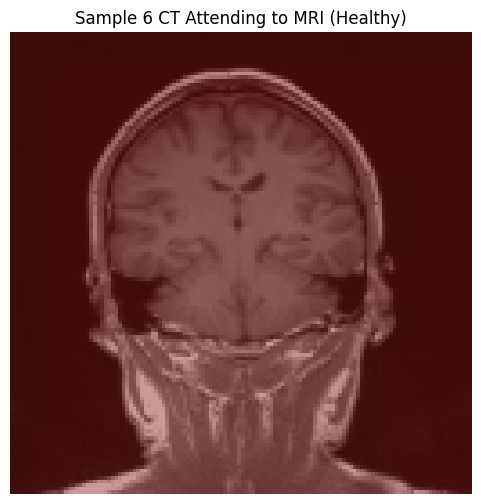

--- Inside visualize_attention_map ---
Received attention_weights shape: torch.Size([256, 256])
Handling unexpected 2D shape [256, 256]. Assuming single head. Shape: torch.Size([256, 256])
Shape after processing unexpected 2D shape: torch.Size([256, 256])
Shape after averaging query patches: torch.Size([256])
Inferred grid size: 16x16, Num patches: 256


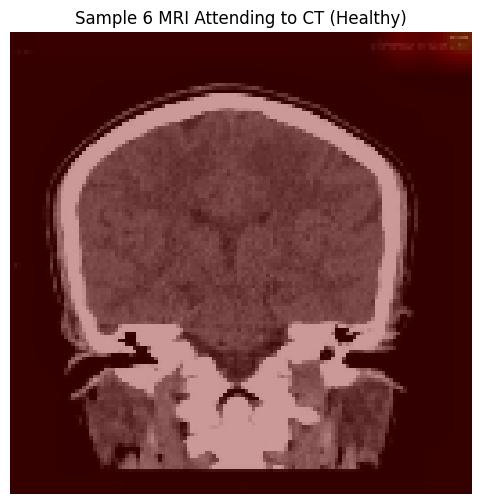

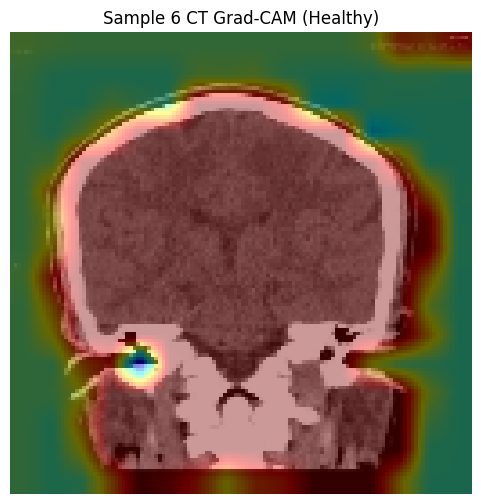

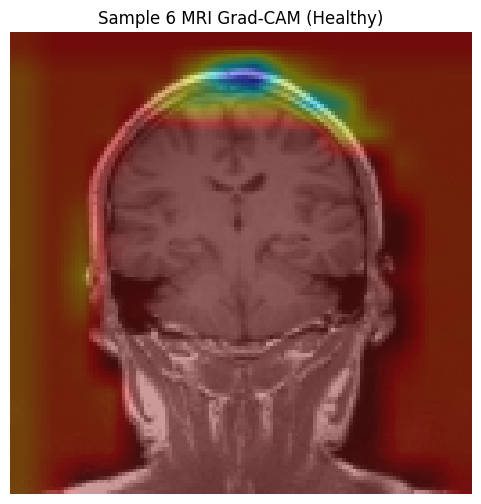

In [ ]:
# Initialize Grad-CAM instances for both the CT and MRI encoders
# Selecting the last convolutional layer in each encoder as the target layer
grad_cam_ct = GradCAM(trained_final_model, trained_final_model.cnn_ct.conv[-1])
grad_cam_mri = GradCAM(trained_final_model, trained_final_model.cnn_mri.conv[-1])

sample_results = []

# Iterate through the selected sample paired images:
print("\nGenerating predictions, attention weights, and Grad-CAM heatmaps for sample images")
for i in range(len(sample_paired_images_viz_df)):
    ct_path = sample_ct_image_paths_viz[i]
    mri_path = sample_mri_image_paths_viz[i]
    true_label = sample_true_labels_viz[i]

    # Use the predict_image_pair_with_attention function to get the predicted label and attention weights
    predicted_label, ct_mri_attn, mri_ct_attn = predict_image_pair_with_attention(trained_final_model, ct_path, mri_path, device=device)

    print(f"Sample {i+1} - Shape of ct_mri_attn returned by predict_image_pair_with_attention: {ct_mri_attn.shape if ct_mri_attn is not None else 'None'}")
    print(f"Sample {i+1} - Shape of mri_ct_attn returned by predict_image_pair_with_attention: {mri_ct_attn.shape if mri_ct_attn is not None else 'None'}")


    ct_heatmap_np = None
    mri_heatmap_np = None

    # If the prediction was successful (predicted label is not None), load and preprocess the images separately for Grad-CAM.
    if predicted_label is not None:
        ct_image_tensor = load_and_preprocess_image(ct_path).unsqueeze(0).to(device)
        mri_image_tensor = load_and_preprocess_image(mri_path).unsqueeze(0).to(device)

        if ct_image_tensor is not None and mri_image_tensor is not None:
             # c. Generate Grad-CAM heatmaps for both the CT and MRI images
             # Pass both tensors to Grad-CAM __call__ as a tuple
             ct_heatmap_np, _ = grad_cam_ct((ct_image_tensor, mri_image_tensor), target_category=predicted_label)
             mri_heatmap_np, _ = grad_cam_mri((ct_image_tensor, mri_image_tensor), target_category=predicted_label)
        else:
            print(f"Warning: Could not load preprocessed tensors for Grad-CAM for sample {i+1}.")


    # Store the results
    sample_results.append({
        'ct_path': ct_path,
        'mri_path': mri_path,
        'true_label': true_label,
        'predicted_label': predicted_label,
        'ct_mri_attention': ct_mri_attn,
        'mri_ct_attention': mri_ct_attn,
        'ct_heatmap': ct_heatmap_np,
        'mri_heatmap': mri_heatmap_np
    })

print("Predictions, attention weights, and Grad-CAM heatmaps generated for sample images.")

# Iterate through the stored sample results and visualize:
print("\nVisualizing results for sample images")
categories = ["Healthy", "Tumor"]

for i, result in enumerate(sample_results):
    ct_path = result['ct_path']
    mri_path = result['mri_path']
    ct_mri_attn = result['ct_mri_attention']
    mri_ct_attn = result['mri_ct_attention']
    ct_heatmap = result['ct_heatmap']
    mri_heatmap = result['mri_heatmap']
    true_label = result['true_label']
    predicted_label = result['predicted_label']

    if predicted_label is not None:
        predicted_label_name = categories[predicted_label]
    else:
        predicted_label_name = "N/A (Image Load Error)"

    print(f"\n--- Sample {i+1}: True Label: {categories[true_label]}, Predicted Label: {predicted_label_name} ---")

    # Visualize attention maps
    # Ensure attention weights are not None and have at least 1 batch dimension
    if ct_mri_attn is not None and ct_mri_attn.ndim >= 3:
         visualize_attention_map(
             mri_path, # Overlay on MRI image (as CT is attending to MRI)
             ct_mri_attn[0], # Explicitly select the first item in the batch
             patch_size=16, img_size=(128, 128),
             title=f"Sample {i+1} CT Attending to MRI ({predicted_label_name})"
         )
    else:
         print(f"Could not visualize CT attention to MRI for Sample {i+1}. Attention weights shape: {ct_mri_attn.shape if ct_mri_attn is not None else 'None'}")


    if mri_ct_attn is not None and mri_ct_attn.ndim >= 3:
        visualize_attention_map(
            ct_path, # Overlay on CT image (as MRI is attending to CT)
            mri_ct_attn[0], # Explicitly select the first item in the batch
            patch_size=16, img_size=(128, 128),
            title=f"Sample {i+1} MRI Attending to CT ({predicted_label_name})"
        )
    else:
        print(f"Could not visualize MRI attention to CT for Sample {i+1}. Attention weights shape: {mri_ct_attn.shape if mri_ct_attn is not None else 'None'}")


    # Visualize Grad-CAM heatmaps
    if ct_heatmap is not None:
         visualize_gradcam_heatmap(
             ct_path,
             ct_heatmap,
             img_size=(128, 128),
             title=f"Sample {i+1} CT Grad-CAM ({predicted_label_name})"
         )
    else:
         print(f"Could not visualize CT Grad-CAM heatmap for Sample {i+1}.")


    if mri_heatmap is not None:
        visualize_gradcam_heatmap(
            mri_path,
            mri_heatmap,
            img_size=(128, 128),
            title=f"Sample {i+1} MRI Grad-CAM ({predicted_label_name})"
        )
    else:
        print(f"Could not visualize MRI Grad-CAM heatmap for Sample {i+1}.")

# Task
Perform an ablation study on the `LightweightDualCrossModalTransformer` model to understand the contribution of different architectural components to its performance.

## Identify components for ablation

### Subtask:
Identify which specific layers or mechanisms in the `LightweightDualCrossModalTransformer` model to ablate.


**Reasoning**:
Identify the architectural components of the model to determine ablation scenarios.



In [ ]:
print("Identified ablation scenarios:")
print("- Scenario 1: Remove Cross-Attention")
print("- Scenario 2: Remove Self-Attention")
print("- Scenario 3: Use Only CT Modality")
print("- Scenario 4: Use Only MRI Modality")
print("- Scenario 5: Use No Attention")


Identified ablation scenarios:
- Scenario 1: Remove Cross-Attention
- Scenario 2: Remove Self-Attention
- Scenario 3: Use Only CT Modality
- Scenario 4: Use Only MRI Modality
- Scenario 5: Use No Attention


## Create ablated model variations

### Subtask:
Create modified versions of the `LightweightDualCrossModalTransformer` class to represent the ablated architectures for each of the identified scenarios.


**Reasoning**:
Define the ablated model classes as per the instructions, creating versions without cross-attention, without self-attention, with only CT modality, and with only MRI modality.



In [ ]:
import torch
import torch.nn as nn

# Scenario 1: Remove Cross-Attention
class LightweightDualCrossModalTransformer_NoCrossAttention(nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, num_classes=2):
        super().__init__()
        # CNN Encoders
        self.cnn_ct = CNNEncoder(1, embed_dim)
        self.cnn_mri = CNNEncoder(1, embed_dim)

        # Self-Attention per modality (lightweight)
        self.self_attn_ct = nn.TransformerEncoderLayer(embed_dim, num_heads, batch_first=True)
        self.self_attn_mri = nn.TransformerEncoderLayer(embed_dim, num_heads, batch_first=True)

        # Classifier takes concatenated pooled features
        # Assuming Global Average Pooling over the sequence dimension after self-attention
        self.fc = nn.Sequential(
            nn.Linear(embed_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, ct_img, mri_img):
        # CNN embeddings (output shape: [B, N_patches, embed_dim])
        ct = self.cnn_ct(ct_img)
        mri = self.cnn_mri(mri_img)

        # Self-attention
        ct = self.self_attn_ct(ct)
        mri = self.self_attn_mri(mri)

        # Apply Global Average Pooling over the sequence dimension
        ct_pooled = torch.mean(ct, dim=1) # Shape [B, D]
        mri_pooled = torch.mean(mri, dim=1) # Shape [B, D]

        # Concatenate pooled features and classify
        fused = torch.cat([ct_pooled, mri_pooled], dim=1)
        logits = self.fc(fused)

        return logits # Return only logits

# Scenario 2: Remove Self-Attention
class LightweightDualCrossModalTransformer_NoSelfAttention(nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, num_classes=2):
        super().__init__()
        # CNN Encoders
        self.cnn_ct = CNNEncoder(1, embed_dim)
        self.cnn_mri = CNNEncoder(1, embed_dim)

        # Dual Cross-Attention
        self.cross_ct_to_mri = CrossAttentionBlock(embed_dim, num_heads)  # MRI attends to CT
        self.cross_mri_to_ct = CrossAttentionBlock(embed_dim, num_heads)  # CT attends to MRI

        # Classifier takes concatenated pooled features
        # Assuming Global Average Pooling over the sequence dimension after cross-attention
        self.fc = nn.Sequential(
            nn.Linear(embed_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, ct_img, mri_img):
        # CNN embeddings (output shape: [B, N_patches, embed_dim])
        ct = self.cnn_ct(ct_img)
        mri = self.cnn_mri(mri_img)

        # Dual Cross-Attention (apply directly after CNN embeddings)
        # CT attends to MRI (query=CT, key=MRI)
        ct, _ = self.cross_mri_to_ct(ct, mri) # Discard attention weights
        # MRI attends to CT (query=MRI, key=CT)
        mri, _ = self.cross_ct_to_mri(mri, ct) # Discard attention weights

        # Apply Global Average Pooling over the sequence dimension
        ct_pooled = torch.mean(ct, dim=1) # Shape [B, D]
        mri_pooled = torch.mean(mri, dim=1) # Shape [B, D]

        # Concatenate pooled features and classify
        fused = torch.cat([ct_pooled, mri_pooled], dim=1)
        logits = self.fc(fused)

        return logits # Return only logits

# Scenario 3: Use Only CT Modality
class LightweightDualCrossModalTransformer_CTOnly(nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, num_classes=2):
        super().__init__()
        # CNN Encoder for CT
        self.cnn_ct = CNNEncoder(1, embed_dim)

        # Self-Attention for CT
        self.self_attn_ct = nn.TransformerEncoderLayer(embed_dim, num_heads, batch_first=True)

        # Classifier takes pooled features from CT
        # Assuming Global Average Pooling over the sequence dimension after self-attention
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, 64), # Input dimension is just embed_dim
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, ct_img, mri_img): # Keep mri_img as input for consistency with dataloader
        # CNN embedding for CT (output shape: [B, N_patches, embed_dim])
        ct = self.cnn_ct(ct_img)

        # Self-attention for CT
        ct = self.self_attn_ct(ct)

        # Apply Global Average Pooling over the sequence dimension
        ct_pooled = torch.mean(ct, dim=1) # Shape [B, D]

        # Classify based on CT pooled features
        logits = self.fc(ct_pooled)

        return logits # Return only logits

# Scenario 4: Use Only MRI Modality
class LightweightDualCrossModalTransformer_MRIOnly(nn.Module):
    def __init__(self, embed_dim=64, num_heads=2, num_classes=2):
        super().__init__()
        # CNN Encoder for MRI
        self.cnn_mri = CNNEncoder(1, embed_dim)

        # Self-Attention for MRI
        self.self_attn_mri = nn.TransformerEncoderLayer(embed_dim, num_heads, batch_first=True)

        # Classifier takes pooled features from MRI
        # Assuming Global Average Pooling over the sequence dimension after self-attention
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, 64), # Input dimension is just embed_dim
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, ct_img, mri_img): # Keep ct_img as input for consistency with dataloader
        # CNN embedding for MRI (output shape: [B, N_patches, embed_dim])
        mri = self.cnn_mri(mri_img)

        # Self-attention for MRI
        mri = self.self_attn_mri(mri)

        # Apply Global Average Pooling over the sequence dimension
        mri_pooled = torch.mean(mri, dim=1) # Shape [B, D]

        # Classify based on MRI pooled features
        logits = self.fc(mri_pooled)

        return logits # Return only logits

# Scenario 5: Remove Both Self and Cross-Attention and CLS Tokens
class LightweightDualCrossModalTransformer_NoAttention(nn.Module):
    def __init__(self, embed_dim=64, num_classes=2): # Removed num_heads as it's not used in this variant
        super().__init__()
        # CNN Encoders
        self.cnn_ct = CNNEncoder(1, embed_dim)
        self.cnn_mri = CNNEncoder(1, embed_dim)

        # Classifier takes concatenated pooled features after CNN embeddings
        # Assuming Global Average Pooling over the sequence dimension
        self.fc = nn.Sequential(
            nn.Linear(embed_dim * 2, 64), # Input dimension is embed_dim * 2
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, ct_img, mri_img):
        # CNN embeddings (output shape: [B, N_patches, embed_dim])
        ct = self.cnn_ct(ct_img)
        mri = self.cnn_mri(mri_img)

        # Apply Global Average Pooling over the sequence dimension
        ct_pooled = torch.mean(ct, dim=1) # Shape [B, D]
        mri_pooled = torch.mean(mri, dim=1) # Shape [B, D]

        # Concatenate pooled features and classify
        fused = torch.cat([ct_pooled, mri_pooled], dim=1)
        logits = self.fc(fused)

        return logits

## Train each ablated model

### Subtask:
Train each of the ablated model variations on the training dataset using the same training procedure and hyperparameters as the full model (or best found hyperparameters).


**Reasoning**:
Train each ablated model variation on the training data using the `train_model` function with hyperparameters similar to the best full model, saving the trained models.



In [ ]:
ablation_params = {'lr': 1e-4, 'weight_decay': 1e-4, 'embed_dim': 32, 'num_heads': 1} # Using parameters from best observed tuning result
#     print(f"Using default/fallback parameters for ablation study: {ablation_params}")


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Instantiate and train LightweightDualCrossModalTransformer_NoCrossAttention
print("\n--- Training Ablated Model: No Cross-Attention ---")
model_no_cross_attention = LightweightDualCrossModalTransformer_NoCrossAttention(
    embed_dim=ablation_params['embed_dim'],
    num_heads=ablation_params['num_heads'],
    num_classes=2
).to(device)

trained_model_no_cross_attention = train_model(
    model_no_cross_attention,
    train_paired_loader,
    valid_paired_loader,
    num_epochs=20,
    lr=ablation_params['lr'],
    weight_decay=ablation_params['weight_decay'],
    device=device,
    patience=7 # Use the same patience as for the augmented model training
)
torch.save(trained_model_no_cross_attention.state_dict(), 'ablated_model_no_cross_attention.pth')
print("Training complete for No Cross-Attention model. Model state saved.")

# Instantiate and train LightweightDualCrossModalTransformer_NoSelfAttention
print("\n--- Training Ablated Model: No Self-Attention ---")
model_no_self_attention = LightweightDualCrossModalTransformer_NoSelfAttention(
    embed_dim=ablation_params['embed_dim'],
    num_heads=ablation_params['num_heads'],
    num_classes=2
).to(device)

trained_model_no_self_attention = train_model(
    model_no_self_attention,
    train_paired_loader,
    valid_paired_loader,
    num_epochs=20,
    lr=ablation_params['lr'],
    weight_decay=ablation_params['weight_decay'],
    device=device,
    patience=7
)
torch.save(trained_model_no_self_attention.state_dict(), 'ablated_model_no_self_attention.pth')
print("Training complete for No Self-Attention model. Model state saved.")

# Instantiate and train LightweightDualCrossModalTransformer_CTOnly
print("\n--- Training Ablated Model: CT Only ---")
model_ct_only = LightweightDualCrossModalTransformer_CTOnly(
    embed_dim=ablation_params['embed_dim'],
    num_heads=ablation_params['num_heads'],
    num_classes=2
).to(device)

trained_model_ct_only = train_model(
    model_ct_only,
    train_paired_loader,
    valid_paired_loader,
    num_epochs=20,
    lr=ablation_params['lr'],
    weight_decay=ablation_params['weight_decay'],
    device=device,
    patience=7
)
torch.save(trained_model_ct_only.state_dict(), 'ablated_model_ct_only.pth')
print("Training complete for CT Only model. Model state saved.")

# Instantiate and train LightweightDualCrossModalTransformer_MRIOnly
print("\n--- Training Ablated Model: MRI Only ---")
model_mri_only = LightweightDualCrossModalTransformer_MRIOnly(
    embed_dim=ablation_params['embed_dim'],
    num_heads=ablation_params['num_heads'],
    num_classes=2
).to(device)

trained_model_mri_only = train_model(
    model_mri_only,
    train_paired_loader,
    valid_paired_loader,
    num_epochs=20,
    lr=ablation_params['lr'],
    weight_decay=ablation_params['weight_decay'],
    device=device,
    patience=7
)
torch.save(trained_model_mri_only.state_dict(), 'ablated_model_mri_only.pth')
print("Training complete for MRI Only model. Model state saved.")
# Instantiate and train LightweightDualCrossModalTransformer_NoAttention
print("\n--- Training Ablated Model: No Attention (Self or Cross) ---")
model_no_attention = LightweightDualCrossModalTransformer_NoAttention(
    embed_dim=ablation_params['embed_dim'],
    num_classes=2 # No num_heads parameter here
).to(device)

trained_model_no_attention = train_model(
    model_no_attention,
    train_paired_loader,
    valid_paired_loader,
    num_epochs=20, # Keep epochs reasonable for debugging
    lr=ablation_params['lr'],
    weight_decay=ablation_params['weight_decay'],
    device=device,
    patience=7
)
torch.save(trained_model_no_attention.state_dict(), 'ablated_model_no_attention.pth')
print("Training complete for No Attention model. Model state saved.")


Using device: cuda

--- Training Ablated Model: No Cross-Attention ---
Epoch 1/20 | Train Loss: 0.4593, Train Acc: 0.8306 | Val Loss: 0.4373, Val Acc: 0.8333
Epoch 2/20 | Train Loss: 0.4074, Train Acc: 0.8329 | Val Loss: 0.3753, Val Acc: 0.8306
Epoch 3/20 | Train Loss: 0.3613, Train Acc: 0.8484 | Val Loss: 0.3683, Val Acc: 0.8417
Epoch 4/20 | Train Loss: 0.3515, Train Acc: 0.8478 | Val Loss: 0.3498, Val Acc: 0.8444
Epoch 5/20 | Train Loss: 0.3530, Train Acc: 0.8573 | Val Loss: 0.3454, Val Acc: 0.8500


KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

ablation_results = {}

# Define a helper function to evaluate a loaded model
def evaluate_loaded_model(model_path, model_class, model_params, test_loader, device):
    """Loads a model and evaluates it on the test set."""
    # Instantiate the model with provided parameters
    model = model_class(**model_params).to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model state from '{model_path}'")
    except FileNotFoundError:
        print(f"Error: '{model_path}' not found. Skipping evaluation for this model.")
        return None
    except RuntimeError as e:
        print(f"Error loading model state dictionary from '{model_path}': {e}")
        return None

    model.eval()
    all_test_preds = []
    all_test_labels = []
    all_test_logits = []

    if test_loader is None:
        print("Error: test_loader is None. Cannot perform evaluation.")
        return None

    with torch.no_grad():
        for ct_img, mri_img, labels in test_loader:
            valid_indices = labels != -1
            if not torch.any(valid_indices):
                continue

            ct_img = ct_img[valid_indices].to(device)
            mri_img = mri_img[valid_indices].to(device)
            labels = labels[valid_indices].to(device)

            if labels.size(0) == 0:
               continue

            # Determine if the model returns logits only or logits and attention weights
            model_output = model(ct_img, mri_img)
            if isinstance(model_output, tuple):
                logits = model_output[0]
            else:
                logits = model_output # Ablated models might return only logits

            _, preds = torch.max(logits, 1)

            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())
            all_test_logits.extend(logits.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_test_labels, all_test_preds)
    precision = precision_score(all_test_labels, all_test_preds, zero_division=0)
    recall = recall_score(all_test_labels, all_test_preds, zero_division=0)
    f1 = f1_score(all_test_labels, all_test_preds, zero_division=0)
    conf_matrix = confusion_matrix(all_test_labels, all_test_preds)

    # Calculate AUC
    try:
        probabilities = torch.softmax(torch.tensor(all_test_logits), dim=1)[:, 1].numpy()
        fpr, tpr, thresholds = roc_curve(all_test_labels, probabilities)
        roc_auc = auc(fpr, tpr)
    except Exception as e:
        print(f"Could not calculate AUC: {e}")
        roc_auc = None

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'conf_matrix': conf_matrix,
        'auc': roc_auc
    }
    return metrics
# It seems embed_dim=32 and num_heads=1 were used based on the best observed tuning result
ablation_model_params = {'embed_dim': 32, 'num_heads': 1}

# Evaluate Ablated Model: No Cross-Attention
print("\n--- Evaluating Ablated Model: No Cross-Attention ---")
metrics_no_cross_attention = evaluate_loaded_model(
    'ablated_model_no_cross_attention.pth',
    LightweightDualCrossModalTransformer_NoCrossAttention,
    model_params={'embed_dim': ablation_model_params['embed_dim'], 'num_heads': ablation_model_params['num_heads'], 'num_classes': 2},
    test_loader=test_paired_loader,
    device=device
)
if metrics_no_cross_attention:
    ablation_results['No Cross-Attention'] = metrics_no_cross_attention
    print(f"Metrics: Accuracy={metrics_no_cross_attention['accuracy']:.4f}, F1={metrics_no_cross_attention['f1_score']:.4f}, AUC={metrics_no_cross_attention['auc']:.4f}")


# Evaluate Ablated Model: No Self-Attention
print("\n--- Evaluating Ablated Model: No Self-Attention ---")
metrics_no_self_attention = evaluate_loaded_model(
    'ablated_model_no_self_attention.pth',
    LightweightDualCrossModalTransformer_NoSelfAttention,
    model_params={'embed_dim': ablation_model_params['embed_dim'], 'num_heads': ablation_model_params['num_heads'], 'num_classes': 2},
    test_loader=test_paired_loader,
    device=device
)
if metrics_no_self_attention:
    ablation_results['No Self-Attention'] = metrics_no_self_attention
    print(f"Metrics: Accuracy={metrics_no_self_attention['accuracy']:.4f}, F1={metrics_no_self_attention['f1_score']:.4f}, AUC={metrics_no_self_attention['auc']:.4f}")

# Evaluate Ablated Model: CT Only
print("\n--- Evaluating Ablated Model: CT Only ---")
metrics_ct_only = evaluate_loaded_model(
    'ablated_model_ct_only.pth',
    LightweightDualCrossModalTransformer_CTOnly,
    model_params={'embed_dim': ablation_model_params['embed_dim'], 'num_heads': ablation_model_params['num_heads'], 'num_classes': 2}, # Note: CTOnly doesn't use num_heads in init
    test_loader=test_paired_loader,
    device=device
)
if metrics_ct_only:
    ablation_results['CT Only'] = metrics_ct_only
    print(f"Metrics: Accuracy={metrics_ct_only['accuracy']:.4f}, F1={metrics_ct_only['f1_score']:.4f}, AUC={metrics_ct_only['auc']:.4f}")

# Evaluate Ablated Model: MRI Only
print("\n--- Evaluating Ablated Model: MRI Only ---")
metrics_mri_only = evaluate_loaded_model(
    'ablated_model_mri_only.pth',
    LightweightDualCrossModalTransformer_MRIOnly,
    model_params={'embed_dim': ablation_model_params['embed_dim'], 'num_heads': ablation_model_params['num_heads'], 'num_classes': 2}, # Note: MRIOnly doesn't use num_heads in init
    test_loader=test_paired_loader,
    device=device
)
if metrics_mri_only:
    ablation_results['MRI Only'] = metrics_mri_only
    print(f"Metrics: Accuracy={metrics_mri_only['accuracy']:.4f}, F1={metrics_mri_only['f1_score']:.4f}, AUC={metrics_mri_only['auc']:.4f}")

# Evaluate Ablated Model: No Attention
print("\n--- Evaluating Ablated Model: No Attention ---")
metrics_no_attention = evaluate_loaded_model(
    'ablated_model_no_attention.pth',
    LightweightDualCrossModalTransformer_NoAttention,
    model_params={'embed_dim': ablation_model_params['embed_dim'], 'num_classes': 2}, # NoAttention doesn't use num_heads
    test_loader=test_paired_loader,
    device=device
)
if metrics_no_attention:
    ablation_results['No Attention'] = metrics_no_attention
    print(f"Metrics: Accuracy={metrics_no_attention['accuracy']:.4f}, F1={metrics_no_attention['f1_score']:.4f}, AUC={metrics_no_attention['auc']:.4f}")

# --- Compare Performance and Report Findings ---

print("\n--- Ablation Study Results Comparison ---")

# Evaluate the full model (trained with data augmentation) as a baseline
if 'trained_model_with_augmentation' in globals() and trained_model_with_augmentation is not None:
    print("\n--- Evaluating Full Model (with Data Augmentation) as Baseline ---")
    # Ensure we use the correct parameters for the full model trained with augmentation
    # Based on cell 3746d051, it was instantiated with embed_dim=64, num_heads=2
    metrics_full_model = evaluate_loaded_model(
        'best_model.pth', # Assuming the best model from augmented training was saved as best_model.pth
        LightweightDualCrossModalTransformer, # Use the full model class
        model_params={'embed_dim': 64, 'num_heads': 2, 'num_classes': 2},
        test_loader=test_paired_loader,
        device=device
    )

# Print comparison table
print("\n--- Ablation Study Performance Comparison on Test Set ---")
print("{:<30} {:<10} {:<10} {:<10} {:<10} {:<10}".format("Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC"))
print("-" * 90)

for model_name, metrics in ablation_results.items():
    if metrics:
        print("{:<30} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
            model_name,
            metrics['accuracy'],
            metrics['precision'],
            metrics['recall'],
            metrics['f1_score'],
            metrics['auc'] if metrics['auc'] is not None else np.nan
        ))
    else:
        print("{:<30} {}".format(model_name, "Evaluation Failed"))




In [ ]:
import torch

def count_parameters(model):
    """
    Counts the number of trainable parameters in a PyTorch model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

if 'trained_final_model' in globals() and trained_final_model is not None:
    num_params = count_parameters(trained_final_model)
    print(f"The LightweightDualCrossModalTransformer model has {num_params:,} trainable parameters.")
else:
    print("Error: trained_final_model is not defined. Please ensure the model is instantiated and trained or loaded.")



In [ ]:
import torch
import numpy as np
import os # Import os module

# Assuming sample_ct_image_paths_viz, sample_mri_image_paths_viz,
# and predict_image_pair_with_attention are available from previous cells.
# Ensure the LightweightDualCrossModalTransformer_NoCLS model class is defined (e.g., from cell 0d273c41)
# Ensure the best_params variable is available from hyperparameter tuning (e.g., from cell 9b6e2be9)

print("\nCalculating statistics for cross-attention weights of sample images:")

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load the trained model state ---
# Assuming the model architecture class (LightweightDualCrossModalTransformer_NoCLS) is defined
# Assuming the best model state was saved to 'final_best_model_with_aug.pth' or 'best_model.pth'
trained_final_model = None
model_state_path_option1 = 'final_best_model_with_aug.pth'
model_state_path_option2 = 'best_model.pth'
loaded_model_path = None

try:
    # Instantiate the model with the correct parameters (based on the best model from tuning)
    # We need the embed_dim and num_heads from the best_params determined in cell 9b6e2be9
    if 'best_params' not in globals() or best_params is None:
        raise NameError("best_params variable not found. Please run the hyperparameter tuning cell (9b6e2be9) first.")

    # Use the parameters from best_params
    model_params = {
        'embed_dim': best_params['embed_dim'],
        'num_heads': best_params['num_heads'],
        'num_classes': 2
    }

    # Instantiate the correct model class (LightweightDualCrossModalTransformer_NoCLS)
    if 'LightweightDualCrossModalTransformer' not in globals():
         raise NameError("LightweightDualCrossModalTransformer class not defined. Please run the cell defining ablated models (0d273c41) first.")

    trained_final_model = LightweightDualCrossModalTransformer(**model_params).to(device)

    # Try loading the first option
    if os.path.exists(model_state_path_option1):
        trained_final_model.load_state_dict(torch.load(model_state_path_option1, map_location=device))
        loaded_model_path = model_state_path_option1
        print(f"Successfully loaded trained model state from '{loaded_model_path}'")
    # If the first option is not found, try the second option
    elif os.path.exists(model_state_path_option2):
        trained_final_model.load_state_dict(torch.load(model_state_path_option2, map_location=device))
        loaded_model_path = model_state_path_option2
        print(f"Successfully loaded trained model state from '{loaded_model_path}'")
    else:
        raise FileNotFoundError(f"Neither '{model_state_path_option1}' nor '{model_state_path_option2}' found.")

    trained_final_model.eval() # Set to evaluation mode

except FileNotFoundError as e:
    print(f"Error: {e}. Cannot calculate attention statistics.")
    trained_final_model = None # Set model to None to prevent further errors
except NameError as e:
     print(f"Error: {e}.")
     trained_final_model = None
except Exception as e:
    print(f"An error occurred while loading the model: {e}")
    trained_final_model = None


sample_attention_stats = []

if trained_final_model is not None: # Proceed only if the model was loaded successfully
    # Ensure predict_image_pair_with_attention function is defined
    if 'predict_image_pair_with_attention' not in globals():
         print("Error: predict_image_pair_with_attention function not defined.")
         trained_final_model = None # Prevent further execution

if trained_final_model is not None:
    for i in range(len(sample_ct_image_paths_viz)):
        ct_path = sample_ct_image_paths_viz[i]
        mri_path = sample_mri_image_paths_viz[i]

        # Get predicted label and attention weights using the helper function
        predicted_label, ct_mri_attn, mri_ct_attn = predict_image_pair_with_attention(
            trained_final_model, ct_path, mri_path, device=device
        )

        stats = {}
        if predicted_label is not None: # Check if image loading and prediction were successful
            print(f"\n--- Sample {i+1} ---")
            if ct_mri_attn is not None:
                # Assuming ct_mri_attn shape is [1, num_heads, seq_len_ct, seq_len_mri]
                # Squeeze batch dimension for calculating stats
                ct_mri_attn_squeezed = ct_mri_attn.squeeze(0) # Shape [num_heads, seq_len_ct, seq_len_mri]
                num_heads = ct_mri_attn_squeezed.size(0)

                print("  CT Attending to MRI Attention Stats:")
                for head in range(num_heads):
                     attn_head = ct_mri_attn_squeezed[head] # Shape [seq_len_ct, seq_len_mri]
                     mean_attn = torch.mean(attn_head).item()
                     max_attn = torch.max(attn_head).item()
                     min_attn = torch.min(attn_head).item()
                     print(f"    Head {head+1}: Mean={mean_attn:.6f}, Max={max_attn:.6f}, Min={min_attn:.6f}")

                    # Need to handle the case where the model does not return attention weights
                    # The current model LightweightDualCrossModalTransformer_NoCLS *does* return attention weights
                    # But some ablated models might not. The predict_image_pair_with_attention needs to handle this.
                    # Let's assume predict_image_pair_with_attention returns None for attn weights if not available.


                # Overall stats across all heads
                mean_attn_overall = torch.mean(ct_mri_attn_squeezed).item()
                max_attn_overall = torch.max(ct_mri_attn_squeezed).item()
                min_attn_overall = torch.min(ct_mri_attn_squeezed).item()
                print(f"    Overall: Mean={mean_attn_overall:.6f}, Max={max_attn_overall:.6f}, Min={min_attn_overall:.6f}")

                stats['ct_mri'] = {'mean': mean_attn_overall, 'max': max_attn_overall, 'min': min_attn_overall}

            else:
                print("  CT Attending to MRI Attention Weights not available.")
                stats['ct_mri'] = None


            if mri_ct_attn is not None:
                # Assuming mri_ct_attn shape is [1, num_heads, seq_len_mri, seq_len_ct]
                mri_ct_attn_squeezed = mri_ct_attn.squeeze(0) # Shape [num_heads, seq_len_mri, seq_len_ct]
                num_heads = mri_ct_attn_squeezed.size(0)

                print("  MRI Attending to CT Attention Stats:")
                for head in range(num_heads):
                     attn_head = mri_ct_attn_squeezed[head] # Shape [seq_len_mri, seq_len_ct]
                     mean_attn = torch.mean(attn_head).item()
                     max_attn = torch.max(attn_head).item()
                     min_attn = torch.min(attn_head).item()
                     print(f"    Head {head+1}: Mean={mean_attn:.6f}, Max={max_attn:.6f}, Min={min_attn:.6f}")

                # Overall stats across all heads
                mean_attn_overall = torch.mean(mri_ct_attn_squeezed).item()
                max_attn_overall = torch.max(mri_ct_attn_squeezed).item()
                min_attn_overall = torch.min(mri_ct_attn_squeezed).item()
                print(f"    Overall: Mean={mean_attn_overall:.6f}, Max={max_attn_overall:.6f}, Min={min_attn_overall:.6f}")

                stats['mri_ct'] = {'mean': mean_attn_overall, 'max': max_attn_overall, 'min': min_attn_overall}
            else:
                print("  MRI Attending to CT Attention Weights not available.")
                stats['mri_ct'] = None

        else:
            print(f"\n--- Sample {i+1} ---")
            print("  Could not process sample (image loading failed or prediction error).")
            stats['ct_mri'] = None
            stats['mri_ct'] = None

        sample_attention_stats.append(stats)
else:
    print("\nSkipping attention statistics calculation due to model loading error.")


print("\nFinished calculating attention statistics for sample images.")

In [ ]:
import numpy as np


print("\nComparing average attention statistics across sample classes:")

# Initialize dictionaries to store statistics per class
class_attention_stats = {0: {'ct_mri': [], 'mri_ct': []},
                         1: {'ct_mri': [], 'mri_ct': []}}

# Group attention statistics by true class label
for i, stats in enumerate(sample_attention_stats):
    true_label = sample_true_labels_viz[i]
    if stats['ct_mri'] is not None:
        class_attention_stats[true_label]['ct_mri'].append(stats['ct_mri'])
    if stats['mri_ct'] is not None:
        class_attention_stats[true_label]['mri_ct'].append(stats['mri_ct'])

# Calculate average statistics for each class
average_class_stats = {}

for class_label, modalities in class_attention_stats.items():
    class_name = categories[class_label]
    average_class_stats[class_name] = {}

    for modality_pair, stats_list in modalities.items():
        if stats_list:
            # Calculate the average of the 'mean', 'max', and 'min' across samples in this class
            avg_mean = np.mean([s['mean'] for s in stats_list])
            avg_max = np.mean([s['max'] for s in stats_list])
            avg_min = np.mean([s['min'] for s in stats_list])
            average_class_stats[class_name][modality_pair] = {
                'avg_mean': avg_mean,
                'avg_max': avg_max,
                'avg_min': avg_min
            }
        else:
             average_class_stats[class_name][modality_pair] = None # No data for this class/modality pair

# Display the average class statistics
print("\nAverage Cross-Attention Statistics per Class:")
for class_name, modalities in average_class_stats.items():
    print(f"\n--- Class: {class_name} ---")
    for modality_pair, stats in modalities.items():
        if stats:
            print(f"  Modality Pair: {modality_pair.upper()}")
            print(f"    Average Mean: {stats['avg_mean']:.6f}")
            print(f"    Average Max:  {stats['avg_max']:.6f}")
            print(f"    Average Min:  {stats['avg_min']:.6f}")
        else:
            print(f"  Modality Pair: {modality_pair.upper()} - No data available")

print("\nFinished comparing average attention statistics.")